## <font color='#000000'>Ad Tracking Fraud Detection<font>


<br>
<img src='images/fraud.png' width="800px">
<br>


### <font color='#333333'>Overview<font>

The following text is the competition's overview. You can find the link to the competition at the end of the presentation.

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

If you want to know more about the competition, please click <a href='https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection'>here</a>.

### <font color='#333333'>Context<font>

Even if the overview summarizes the purpose, it is not enough. Let's try to explain what's the real goal of the competition. The title is "Ad Tracking and Fraud Detection", however the response column "is_attributed" can take two values: 1 if the user downloaded the application, 0 otherwise. Why this choice of variable? Let's try to understand by explaining each variable:
<ul>
    <li><b>ip: </b>ip address of click.</li>
    <li><b>app: </b>app id for marketing..</li>
    <li><b>device: </b>device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)</li>
    <li><b>os: </b>os version id of user mobile phone.</li>
    <li><b>channel: </b>channel id of mobile ad publisher.</li>
    <li><b>click_time: </b>timestamp of click (UTC).</li>
    <li><b>attributed_time: </b>if user download the app for after clicking an ad, this is the time of the app download.</li>
    <li><b>is_attributed: </b>the target that is to be predicted, indicating the app was downloaded.</li>
</ul>

Obviously for the final test, we do not have access to "attributed_time" and "is_attributed". Another variable "click_id" is added which will be the reference for the click prediction. The following schema summarizes the situation.

<img src='images/talkingdata_schema.png' width="600px">

Let's say that a user is playing a game inside his mobile. 

<img src='images/belote1.png' width="600px">

A marketing channel can propose to click in an add in order to download another application. 

<img src='images/belote2.png' width="600px">

If we click, we are redirect to another platform (for example, Apple Store). In that case, the click is recorded and it is part of the dataset. We can then choose either to download or not download the application.

<img src='images/belote3.png' width="300px">

We can easily see that some applications will require an ID confirmation and others will be easily download without any ID checking. However, when someone downloads an application, he has to wait some time before being able to download again. The competition has a real problem as we are required to track downloading, but sometimes even fraudulent machines download. The marketing channels can earn a lot of money thanks to clicks. As downloading is a waste of time, they will click a lot and download a small number of applications (and who cares about fraudulent machines downloading?). Tracking fraudulent machines can help the applications to not waste money. 

In this notebook, we will try to predict the competition response column ("is_attributed") and discover trends relevant to fraud detection in the context of BIG DATA. We can see reading the Kaggle discussions that most of people are trying to increase their score slightly without considering the deployment of the model and without understanding their variables. Talking Data is ingesting billions of clicks per day. They need a model which will be easy to apply and deploy in the future. They also need to understand the value of each variable and why the ML model works. Fraudulent machines will change their techniques during the time and the company needs to be able to adapt. 

Finally, we need to build a model that the company can deploy easily using very simply created variables. If the model is hard to create, each time they will need to learn using new data, and valuable time will be wasted. In the other hand, if the variables are hard to create, they will waste time in the data preparation. An accurate and fast model is always better than a perfectly accurate but slow one.

During this tutorial, we will combine Vertica-ML-Python (This library proposes to use a Python object. It will interact with Vertica using methods which will generate a SQL pipeline) and SQL Magic (direct Jupyter interaction using an ODBC connection to Vertica) in order to use all the power of Vertica. We will also use direct Python code when it is needed or simply to give an example of what the Python code looks like. As we know that Talking Data is using both NoSQL and SQL databases, they can try to adapt their code (even if some Vertica functions are not available with regular SQL). The most important takeaway hereh is the reasoning behind the methods we demonstrate.

### <font color='#333333'>Metric to score?<font>

In this Kaggle competition, score is based on the AUC.

<img src='images/auc.png' width="400px">

Indeed, the accuracy means little to nothing here as the response column is totally unbalanced. We can see an approximation of our score for each submission (Public Leader Board) and we will have the final result in the Private Leaderboard. By using a little trick and by being a little bit curious, we can see that the Public Leader Board is measured using hour 4 of the testing day whereas the private is obtained using the hours 5 to 15. If the hour has a real influence, it is really important to have this information. A primary drawbrack to Kaggle's evaulation is that it can not judge the computation time of a model. The user will submit some predictions but no one knows how he generated the file. That is why Kaggle is not adapted to the context of BIG DATA yet (it will with time for sure). In this context, the best way to evaluate the competition model is to see its AUC standard deviation (using different validation folds), its averaged AUC and the computation time. We can for example learn on day 1, 2 and 3 to predict on day 4, 5, 6. We can see the different AUC of the model and have all the information we need. We can after put more weight on one of the metrics. For example, a good model will maximize the following function:

$$\frac{t_{mark}}{3}+\frac{\sigma_{mark}}{4}+\frac{auc_{mark}}{2}$$

We can also add some condition like the following:

$$auc>0.96$$

In the competition, only the AUC counts. Let's begin the real work.

### <font color='#333333'>Loading File and importing libraries<font>
    
Let's first load all the libraries.

In [1]:
from vertica_ml_python import RVD
from vertica_ml_python import load_model
import pyodbc
%load_ext sql
%sql vertica+pyodbc://sandbox

'Connected: None@None'

The RVD is the Python object which will generate the Python pipeline. The following schema summarizes the principes.

<img src='images/RVD.png' width="600px">

The main advantage of the object is that it does not load any data in memory. It will send a SQL query to the database in order to have only the necessary information. We created a specific schema (vpython) inside our Vertica cluster to deal with specific use cases.  

We can create the two tables (train and test) as follows:

In [24]:
%%sql
drop table if exists vpython.AdFraudDetection;
create table vpython.AdFraudDetection
(
    ip int,
    app int,
    device int,
    os int,
    channel int,
    click_time timestamp,
    attributed_time timestamp,
    is_attributed int
);
copy vpython.AdFraudDetection from '/home/dbadmin/train.csv' delimiter ',';

Done.
Done.


[]

In [23]:
%%sql
drop table if exists vpython.AdFraudDetection_f_test;
create table vpython.AdFraudDetection_f_test
(
    click_id int,
    ip int,
    app int,
    device int,
    os int,
    channel int,
    click_time timestamp
);
copy vpython.AdFraudDetection_f_test from '/home/dbadmin/test.csv' delimiter ',';

Done.
Done.


[]

The second table will be used for Kaggle submissions. We can look at the repartition of the test and train to see if we will need some data preparation before the first exploration.

In [4]:
%%sql
select
    count(*)
from vpython.AdFraudDetection;

1 rows affected.


count
184903890


In [6]:
%%sql
select
    min(click_time) as min,
    max(click_time) as max
from vpython.AdFraudDetection;

1 rows affected.


min,max
2017-11-06 14:32:21,2017-11-09 16:00:00


We are dealing with 184903890 clicks among 4 days (only two are complete) for the training.

In [5]:
%%sql
select
    count(*)
from vpython.AdFraudDetection_f_test;

1 rows affected.


count
18790469


In [7]:
%%sql
select
    min(click_time) as min,
    max(click_time) as max
from vpython.AdFraudDetection_f_test;

1 rows affected.


min,max
2017-11-10 04:00:00,2017-11-10 15:00:00


For the testing, we just have one part of a day. Due to Kaggle limitation, Talking Data chose some specific hours with a lot of activity. Let's now try to see the clicks activity per hour. 

In [2]:
%%sql
select
    hour(click_time),
    count(*)
from vpython.AdFraudDetection group by 1 order by 1;

24 rows affected.


hour,count
0,10416435
1,9456661
2,9750363
3,9743476
4,11223316
5,10059359
6,9471879
7,9265535
8,8582051
9,9015837


There is a real variance of the number of clicks between the different hours. We have to remember that the data are from China (UTC+8) so the click time is not the local hour.

In [3]:
%%sql
select
    hour(click_time),
    count(*)
from vpython.AdFraudDetection_f_test group by 1 order by 1;

9 rows affected.


hour,count
4,3344125
5,2858427
6,381
9,2984808
10,3127993
11,413
13,3212566
14,3261257
15,499


The repartition of the test is really weird as we do not have access to successive hours clicks. In that case it can be hard to use different strategies (like sessions or time windows) in order to find some patterns. However, the company shared another dataset.

The test supplement dataset will bring us more information about the use case. This is a larger test set that was unintentionally released at the start of the competition. It is not necessary to use this data, but it is permitted to do so. The official test data is a subset of this data. Let's load it.

In [22]:
%%sql
drop table if exists vpython.AdFraudDetection_f_test_sup;
create table vpython.AdFraudDetection_f_test_sup
(
    click_id int,
    ip int,
    app int,
    device int,
    os int,
    channel int,
    click_time timestamp
);
copy vpython.AdFraudDetection_f_test_sup from '/home/dbadmin/test_supplement.csv' delimiter ',';

Done.
Done.


[]

We can then merge it with the test set using the following command.

In [21]:
%%sql
drop table if exists vpython.AdFraudDetection_f_test_and_sup;
create table vpython.AdFraudDetection_f_test_and_sup as
    select 
        click_id,
        click_time,
        ip,
        os,
        device,
        app,
        channel
    from
        (select
            (case 
                when row_number() over (partition by test.click_id) = 1 and test.click_id is not null then test.click_id 
                when row_number() over (partition by test.click_id) > 1 and test.click_id is not null then -1
                else null
            end) as click_id,
            coalesce(test.ip, test_sup.ip) as ip,
            coalesce(test.os, test_sup.os) as os,
            coalesce(test.device, test_sup.device) as device,
            coalesce(test.channel, test_sup.channel) as channel,
            coalesce(test.click_time, test_sup.click_time) as click_time,
            coalesce(test.app, test_sup.app) as app
        from 
            (select 
                 *, 
                 row_number() over (partition by click_time, channel, app, ip, device, os) as row_id
             from vpython.AdFraudDetection_f_test_sup) test_sup 
                 left join 
            (select 
                 *, 
                 row_number() over (partition by click_time, channel, app, ip, device, os) as row_id
             from vpython.AdFraudDetection_f_test) test 
                on 
            test_sup.click_time = test.click_time and
            test_sup.channel = test.channel and
            test_sup.app = test.app  and
            test_sup.ip = test.ip and
            test_sup.device = test.device and
            test_sup.os = test.os and
            test_sup.row_id = test.row_id) x where (click_id is null or click_id >= 0);

Done.
Done.


[]

The command is a little bit complex because of the duplicated rows inside the test sup (for example when people will click many times). We need to map the click_id of the testing to the one of the test sup (the click ids are not the same). The query will map on the first match. We can then use different strategies to predict. Let's begin the real data exploration.

During all the study, we will use the following machine.

In [14]:
%%sql 
select * from host_resources;

1 rows affected.


host_name,open_files_limit,threads_limit,core_file_limit_max_size_bytes,processor_count,processor_core_count,processor_description,opened_file_count,opened_socket_count,opened_nonfile_nonsocket_count,total_memory_bytes,total_memory_free_bytes,total_buffer_memory_bytes,total_memory_cache_bytes,total_swap_memory_bytes,total_swap_memory_free_bytes,disk_space_free_mb,disk_space_used_mb,disk_space_total_mb
10.3.230.202,131072,129022,2146664448,2,32,Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz,8,10,7,135290130432,72355622912,336707584,22851956736,4295487488,4295487488,5862643,1173988,7036632


### <font color='#333333'>Data Exploration<font>

#### <font color='#1E90FF'>First Look<font>

Let's explore the data in order to understand what's going on:
<ul>
    <li>Detect Fraudulent clicks (They will destroy the prediction by clicking a lot and download a small number of times).</li>
    <li>Create new features that will help to understand users behaviour.</li>
    <li>Understand the importance of each features.</li>
    <li>Detect when users and fraudulent machines will download.</li>
</ul>
We can create a RVD to explore the data.

In [22]:
AdFraudDetection=RVD("vpython.AdFraudDetection",dsn="sandbox")

Let's have a first look on the dataset.

In [15]:
AdFraudDetection["click_time"].describe()

,value
count,184903890
min,2017-11-06 14:32:21
max,2017-11-09 16:00:00


<column_matrix>

In [11]:
AdFraudDetection.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,228445,18,1,13,107,2017-11-08 01:54:21,None,0
1,228450,2,1,14,435,2017-11-09 07:00:11,None,0
2,228450,3,1,13,280,2017-11-08 15:49:03,None,0
3,228450,3,1,14,424,2017-11-09 07:01:22,None,0
4,228450,3,1,14,480,2017-11-09 07:00:09,None,0
5,228450,8,1,13,145,2017-11-09 10:51:20,None,0
6,228450,9,1,13,244,2017-11-09 10:52:46,None,0
7,228450,9,1,13,442,2017-11-09 10:52:06,None,0
8,228450,11,1,6,487,2017-11-09 05:22:56,None,0
9,228450,12,1,14,424,2017-11-09 07:00:38,None,0


Name: AdFraudDetection, Number of rows: 184903890, Number of columns: 8


The dataset only contains categorical features. Even with this configuration, it is still relevant to describe the dataset in order to have a first look at the variables repartitions and cardinalities.

In [12]:
AdFraudDetection.describe()

,count,mean,std,min,25%,50%,75%,max,cardinality
app,184903890,12.0113127582057,14.8052103977009,0.0,3.0,12.0,15.0,768.0,706
channel,184903890,268.578856231734,129.588152063659,0.0,140.0,258.0,379.0,500.0,202
device,184903890,21.7232516525146,259.332644718838,0.0,1.0,1.0,1.0,4227.0,3475
ip,184903890,90876.0419679295,69527.8947304197,1.0,40023.7967938559,79830.6845587681,118266.985868868,364778.0,277396
is_attributed,184903890,0.00247072141099862,0.0496449087020738,0.0,0.0,0.0,0.0,1.0,2
os,184903890,22.6770214028494,55.2528173829857,0.0,13.0,18.0,19.0,956.0,800


<column_matrix>

The dataset contains 4 days. In this one 0.247072141099862% only are downloading. Besides, some os and device are more present than others. For example, the device 1 represents more than 75% of the dataset. 

We can also see when the users are downloading the different applications.

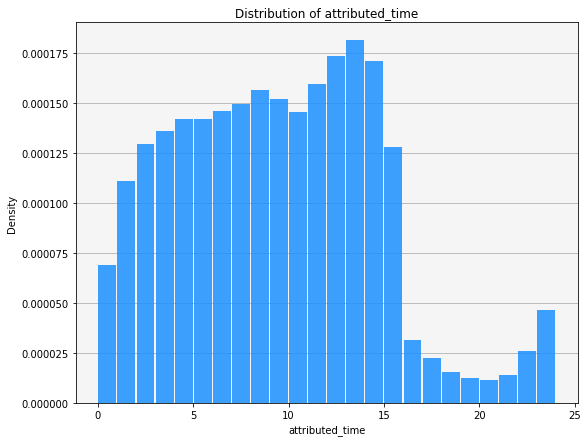

In [23]:
AdFraudDetection["attributed_time"].date_part("hour")
AdFraudDetection["attributed_time"].hist(h=1)

And when they are clicking.

The new RVC 'hour' was added to the RVD.


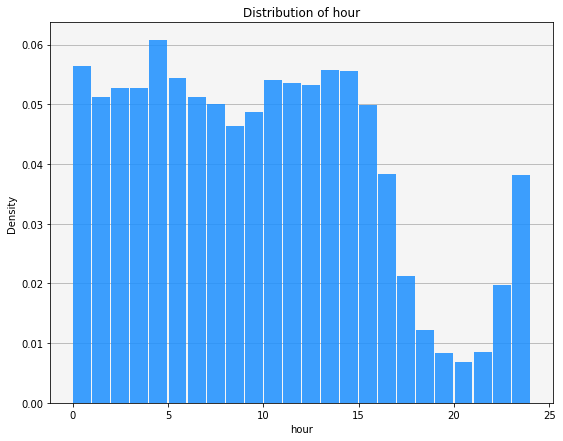

In [24]:
AdFraudDetection.add_feature("hour","hour(click_time)")
AdFraudDetection["hour"].hist(h=1)

We can see that at night and during some hours in the morning, there are less downloading for more clicks which is really suspect (from 22 UTC+0 to 02 UTC+0 for example). Are they clicks from regular users or fraudulent machines?

Lets now see the influence of the channels as they can win a lot of money thanks to fraudulent machines. 

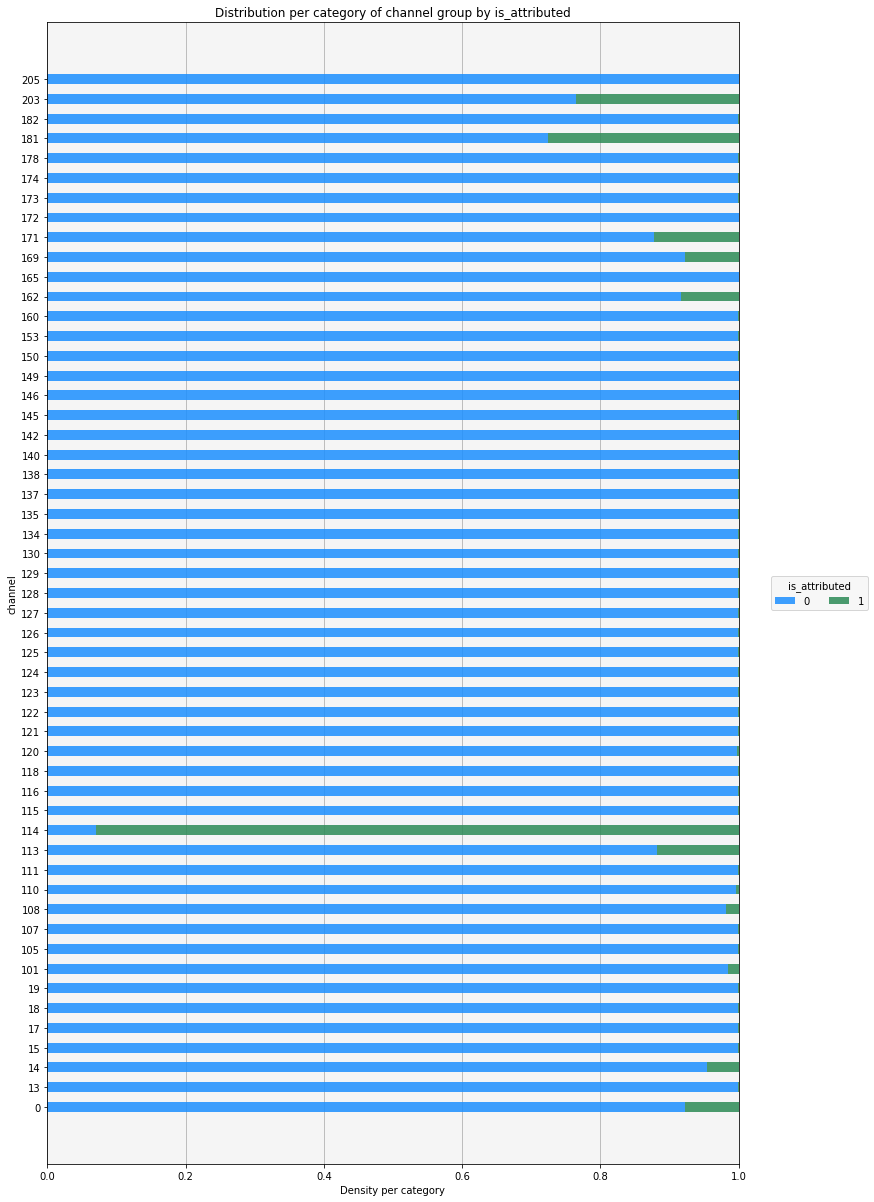

In [16]:
AdFraudDetection.set_figure_size((16,21))
AdFraudDetection.fully_stacked_bar(["channel","is_attributed"],h=[1,1],limit_distinct_elements=50)
AdFraudDetection.set_figure_size()

As expected, some channel are really suspicious. Let's now see the influence of the application.

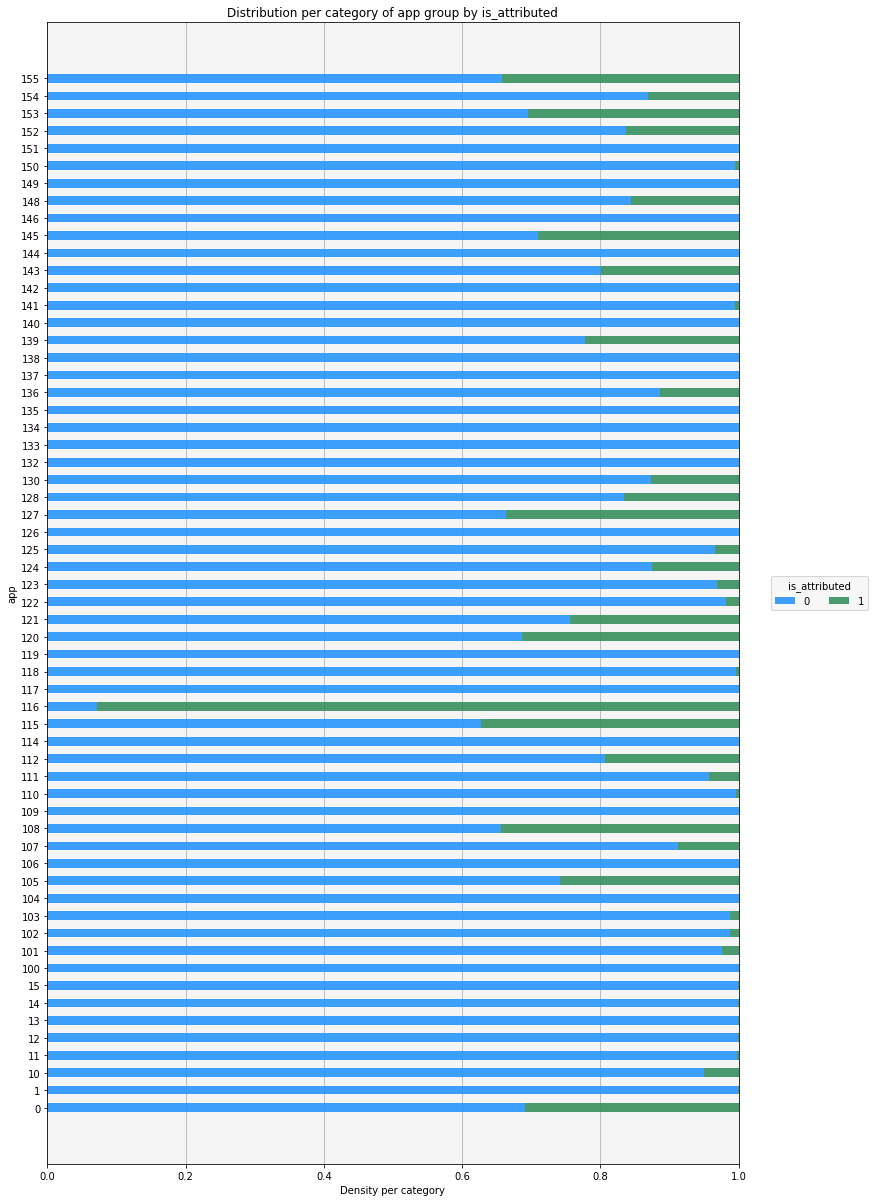

In [17]:
AdFraudDetection.set_figure_size((16,21))
AdFraudDetection.fully_stacked_bar(["app","is_attributed"],h=[1,1],limit_distinct_elements=100)
AdFraudDetection.set_figure_size()

The applications are the fraud victims. That's why it is more balanced for this variable. But still, it is weird to click hundreds or thousands of times on the same application without downloading.

The device and os also influence the prediction, as fraudulent machines can perhaps use specific os and devices, or simply because some devices have a very smart way to influence users' behavior (it is so easy to download an application using an Iphone). 

For the IP, it is totally useless as the same user can have different IP. Using sessions can therefore be really important as it will be very rare for different users to use the same IP, os and device during a certain time. We can then detect some fraudulent machines.

#### <font color='#1E90FF'>Some Fraudulent Machines<font>

Detecting fraudulent machines is quite simple since we can readily detect some strange behaviors. Let's see the number of downloading per application.

In [4]:
%%sql
select 
    app, 
    count(*) as count, 
    sum(is_attributed) as total_downloading 
from vpython.AdFraudDetection group by 1 order by 2 desc; 

706 rows affected.


app,count,total_downloading
3,33911780,10261
12,24179003,2640
2,21642136,5661
9,16458268,18823
15,15958970,3418
18,15756587,7919
14,10027169,2505
1,5796274,1230
13,4329409,721
8,3731948,6875


Some clicks are really suspicious. For example, app 151 has 188490 clicks and no downloads. We can suspect these clicks to be fraudulent. Let's look at them.

In [3]:
%%sql
select 
    *,
    timestampdiff('second', lag(click_time) over (partition by ip, app order by click_time), click_time)
from vpython.AdFraudDetection where app=151 order by ip, click_time limit 200; 

200 rows affected.


ip,app,device,os,channel,click_time,attributed_time,is_attributed,timestampdiff
92,151,0,50,347,2017-11-07 07:59:58,None,0,None
92,151,0,50,347,2017-11-07 08:00:03,None,0,5
92,151,0,50,347,2017-11-07 08:00:09,None,0,6
92,151,0,50,347,2017-11-07 08:00:14,None,0,5
92,151,0,50,347,2017-11-07 08:00:19,None,0,5
92,151,0,50,347,2017-11-07 08:00:24,None,0,5
92,151,0,50,347,2017-11-07 08:00:29,None,0,5
92,151,0,50,347,2017-11-07 08:00:34,None,0,5
92,151,0,50,347,2017-11-07 08:00:39,None,0,5
92,151,0,50,347,2017-11-07 08:00:44,None,0,5


We detected a very weird fraudulent machine. This one is clicking each 5s in the same app. We saw the machine changing its IP to have the exact same behaviour some hours after. The same behaviour is also detected in another machine. Most of all, only the channel 347 is concerned. 

The sessionization is then very important for detecting these fraudulent machines. So we will use the hypothesis that it is highly improbably that different users are using the same IP, os and device at the same moment. 

Let's now see another weird behavior.

In [6]:
%%sql
select 
    *,
    timestampdiff('second', click_time, lead(click_time) over (partition by ip, app order by click_time))
from vpython.AdFraudDetection where day(click_time)=7 and ip=20 order by click_time limit 200; 

200 rows affected.


ip,app,device,os,channel,click_time,attributed_time,is_attributed,timestampdiff
20,12,1,10,245,2017-11-07 00:00:17,None,0,50
20,15,1,10,245,2017-11-07 00:00:17,None,0,50
20,18,1,10,121,2017-11-07 00:00:17,None,0,50
20,12,1,10,245,2017-11-07 00:01:07,None,0,15
20,15,1,10,245,2017-11-07 00:01:07,None,0,15
20,18,1,10,121,2017-11-07 00:01:07,None,0,15
20,12,1,10,245,2017-11-07 00:01:22,None,0,42
20,15,1,10,245,2017-11-07 00:01:22,None,0,42
20,18,1,10,121,2017-11-07 00:01:22,None,0,42
20,12,1,10,245,2017-11-07 00:02:04,None,0,11


This machine is clicking randomnly into 3 applications at the same time. We can see the same behavior many times using the same IP. We can see between the clicks some regular clicks where the os is different to the fraudulent machine. This seems to support our hypothesis.

In the next session, we will only try to detect fraudulent machines. We will obviously use the response column. It is another study which can be more useful than predicting if a specific user will or not download an application. As the IP is always changing, we can not propose specific adds for some specific users and that's why it is more relevant to detect fraudulent machines. Nevertheless, we will use the different information we obtained to try to reach a good score in the Kaggle competition.

### <font color='#333333'>Features Engineering: Sessions<font>

After this small exploration, we can create the following features:
<ul>
    <li>The session (considering that after 30 minutes of inactivity for a same user [= same ip, os, device] or if there is a downloading then the session ends)
    <li>The number of clicks per session
    <li>The number of clicks per session on the same app
    <li>The number of clicks per session on the same channel
    <li>The session duration
    <li>The click iqr for a same session using different partitions
    <li>The time until the next click (same for last)
</ul>

In [20]:
%%sql
drop table if exists vpython.AdFraudDetection_session;
create table vpython.AdFraudDetection_session as 
    select 
        click_time,
        ip,
        os,
        device,
        channel,
        app,
        is_attributed,
        last_time_click,
        next_time_click,
        timestampdiff('second', min(click_time) over (partition by ip, os, device, session), max(click_time) over (partition by ip, os, device, session)) as session_duration,
        timestampdiff('second', click_time, attributed_time) as download_delta,
        count(*) over (partition by ip, os, device, session) as count_session_click,
        count(*) over (partition by ip, os, device, session, app) as count_session_app_click,
        count(*) over (partition by ip, os, device, session, channel) as count_session_channel_click,
        (percentile_cont(.75) within group(order by next_time_click) over (partition by ip, os, device, session) - percentile_cont(.25) within group(order by next_time_click) over (partition by ip, os, device, session)) as click_session_iqr,
        (percentile_cont(.75) within group(order by next_time_app_click) over (partition by ip, os, device, app, session) - percentile_cont(.25) within group(order by next_time_app_click) over (partition by ip, os, device, app, session)) as click_session_app_iqr
    from
        (select
            *,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip, os, device order by click_time)) as next_time_click,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip, os, device, app order by click_time)) as next_time_app_click,
            timestampdiff('second', lag(click_time) over (partition by ip, os, device order by click_time), click_time) as last_time_click,
            conditional_true_event(click_time - lag(click_time) > '30 minutes' or is_attributed = 1) over (partition by ip, os, device order by click_time) as session
        from vpython.AdFraudDetection) x;

Done.
Done.


[]

### <font color='#333333'>Catching fraudulent machines<font>
    
Let's now try to detect fraudulent machines.

<img src='images/fraudulent.png' width="400px">

We can say that the following behaviour are quite suspicious:
<ul>
    <li>Clicking a lot of time without downloading.</li>
    <li>Clicking a lot of time in the same application or channel.</li>
    <li>Clicking many times and having a small IQR (i.e. clicking a lot with the same delta duration). The variance is not meaningful because of outliers whereas IQR is not sensible to outliers.</li>
    <li>Having a very long session duration.</li>
    <li>Clicking too fast without having the time to click again.</li>
    <li>Downloading the application too fast.</li>
</ul>

In [23]:
%%sql
select 
    count(*),
    sum(is_attributed)
from vpython.AdFraudDetection_session 
where 
    next_time_click is null or next_time_click>60;

1 rows affected.


count,sum
50828256,377303


In [31]:
%%sql
select 
    count(*),
    sum(is_attributed)
from vpython.AdFraudDetection_session 
where 
    count_session_click<5;

1 rows affected.


count,sum
21837927,345214


In [34]:
%%sql
select 
    count(*),
    sum(is_attributed)
from vpython.AdFraudDetection_session 
where 
    count_session_app_click=1;

1 rows affected.


count,sum
42051083,407754


In [42]:
%%sql
select 
    count(*),
    sum(is_attributed)
from vpython.AdFraudDetection_session 
where 
    click_session_app_iqr>200 or click_session_app_iqr is null;

1 rows affected.


count,sum
31132384,227090


As expected, most of the downloading are following regular behavior but we can see a lot of downloading from weird machines.

In [2]:
%%sql
select 
    ip,
    app,
    channel,
    os,
    device,
    count_session_click,
    count_session_app_click,
    count_session_channel_click,
    session_duration
from vpython.AdFraudDetection_session 
where 
    count_session_click>40 and count_session_channel_click>20 and is_attributed=1 limit 20;

20 rows affected.


ip,app,channel,os,device,count_session_click,count_session_app_click,count_session_channel_click,session_duration
61332,8,145,19,1,127,24,24,8160
63051,18,107,19,1,792,77,34,37522
63812,3,480,19,1,1726,303,25,76358
64142,8,145,19,1,507,22,23,32485
64320,18,107,19,1,551,56,22,30134
27038,17,280,19,1,152,1,25,8751
27526,9,134,13,1,1248,124,45,67973
27993,9,334,19,1,536,57,26,34637
28013,13,477,13,1,536,23,34,28869
28046,12,245,19,1,647,101,64,44735


We detected some very weird IP that are clicking a lot of times in the same channel (and/or app) to download after a very huge session duration and a very big amount of clicks. Smart fraudulent machines can click 300 times to download at the end. As explained before, the purpose of the Kaggle competition is to predict if the user will download or not the application. What if it is a fraudulent machine? Is the download valuable information? The answer is not particularly, as they can randomly download an application to be less suspected. The fraudulent machines can represent 50% of the downloading and 90% of the clicks. Let's plot some chart to explain what's going on.

In [2]:
AdFraudDetection=RVD("AdFraudDetection_session",dsn="sandbox")

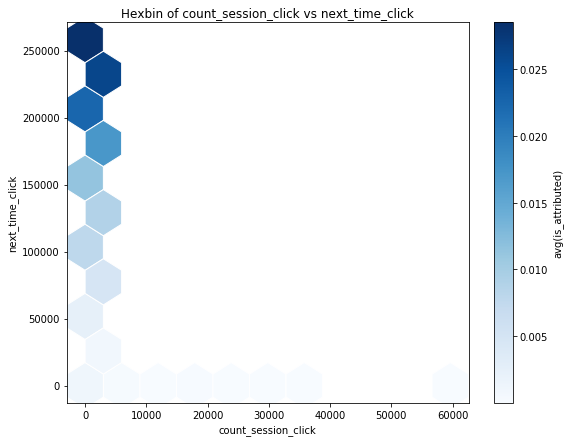

In [41]:
AdFraudDetection.hexbin(["count_session_click","next_time_click"],method="mean",of="is_attributed")

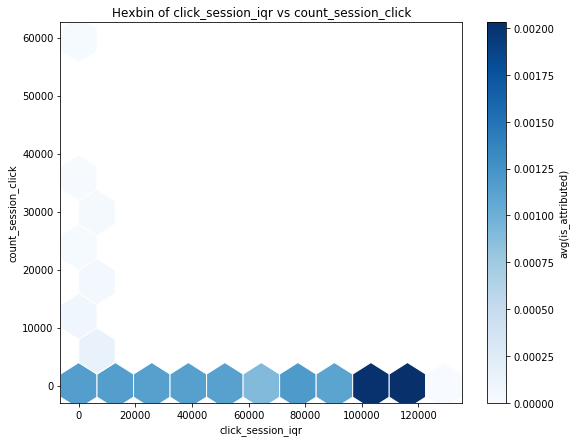

In [6]:
AdFraudDetection.hexbin(["click_session_iqr","count_session_click"],method="mean",of="is_attributed")

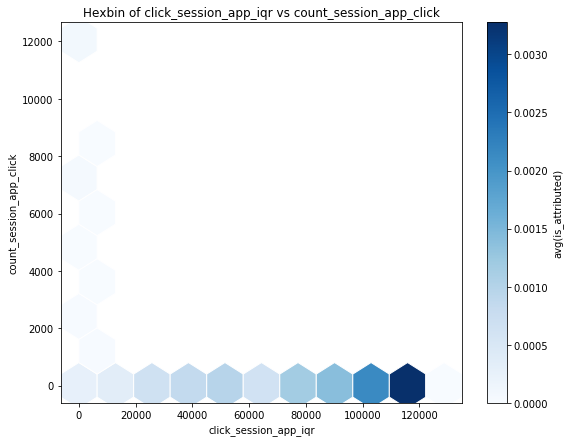

In [7]:
AdFraudDetection.hexbin(["click_session_app_iqr","count_session_app_click"],method="mean",of="is_attributed")

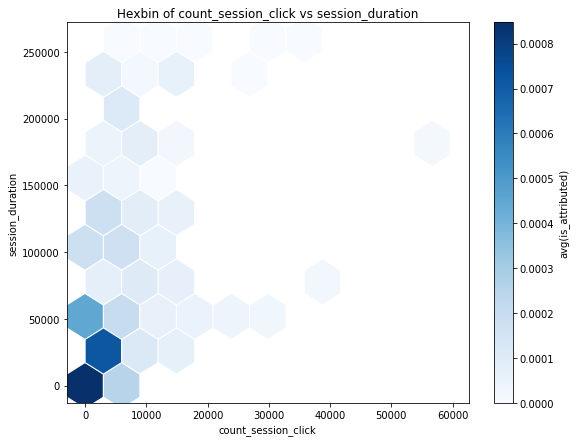

In [8]:
AdFraudDetection.hexbin(["count_session_click","session_duration"],method="mean",of="is_attributed")

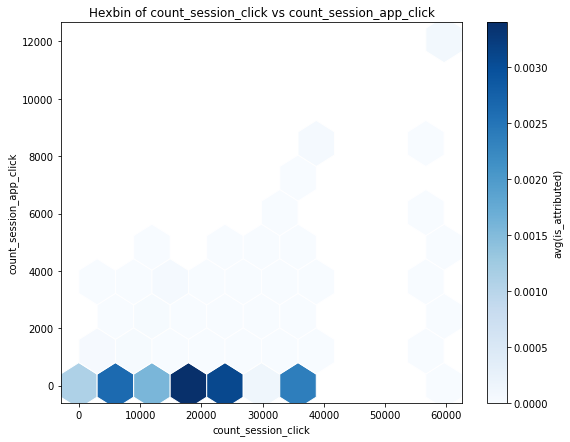

In [9]:
AdFraudDetection.hexbin(["count_session_click","count_session_app_click"],method="mean",of="is_attributed")

With the precedant hexbin plots, we can see the influence of the IQR and the number of clicks on the same app. Besides, the time until the next click seems to be really important. In order to understand users behaviour, it is preferable to use a balanced dataset. Let's do some under sampling.

In [19]:
%%sql
drop view if exists vpython.AdFraudDetection_balance;
select balance('vpython.AdFraudDetection_balance',
               'vpython.AdFraudDetection_session',
               'is_attributed',
               'under_sampling');
drop table if exists vpython.AdFraudDetection_explore;
create table vpython.AdFraudDetection_explore as 
    select 
        *
    from vpython.AdFraudDetection_balance;

Done.
Done.


[]

In [11]:
AdFraudDetection=RVD("AdFraudDetection_explore",dsn="sandbox")

197935 elements were filtered


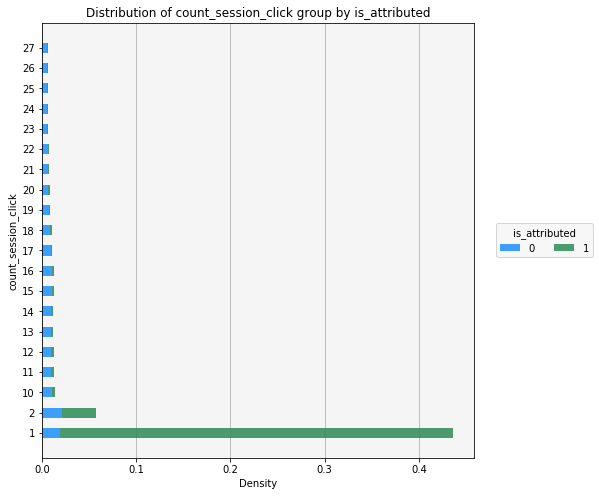

In [16]:
AdFraudDetection.filter("count_session_click<100")
AdFraudDetection.set_figure_size((10,8))
AdFraudDetection.stacked_bar(["count_session_click","is_attributed"],h=[1,1],limit_distinct_elements=40)
AdFraudDetection.set_figure_size()
AdFraudDetection.undo_filter()

We can see that almost all the downloading are during the first clicks.

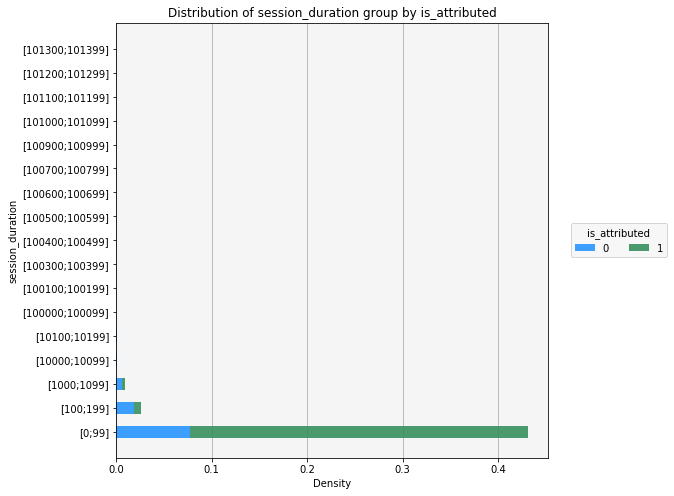

In [17]:
AdFraudDetection.set_figure_size((10,8))
AdFraudDetection.stacked_bar(["session_duration","is_attributed"],h=[100,1],limit_distinct_elements=30)
AdFraudDetection.set_figure_size()

We can see that most of the downloading have a small session duration.

47991 elements were filtered


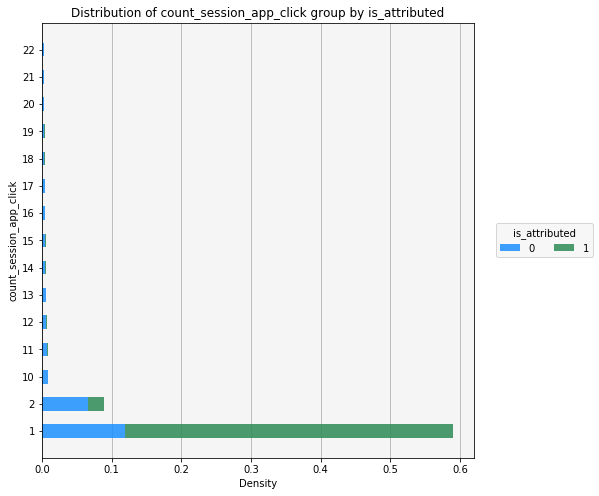

In [18]:
AdFraudDetection.filter("count_session_app_click<100")
AdFraudDetection.set_figure_size((10,8))
AdFraudDetection.stacked_bar(["count_session_app_click","is_attributed"],h=[1,1],limit_distinct_elements=30)
AdFraudDetection.set_figure_size()
AdFraudDetection.undo_filter()

We can see that almost all the downloading are during the first app click. Let's filter and see what's going on.

In [23]:
AdFraudDetection=RVD("AdFraudDetection_explore",dsn="sandbox")
AdFraudDetection.filter("count_session_app_click<=4")
AdFraudDetection.filter("session_duration<=1000")
print(AdFraudDetection["is_attributed"].describe())
AdFraudDetection.undo_all_filters()

253442 elements were filtered
177445 elements were filtered


,value
1,357015
0,125077


<column_matrix>


We can again see the influence of this variable as downloading is following a specific rule. Let's see the application influence.

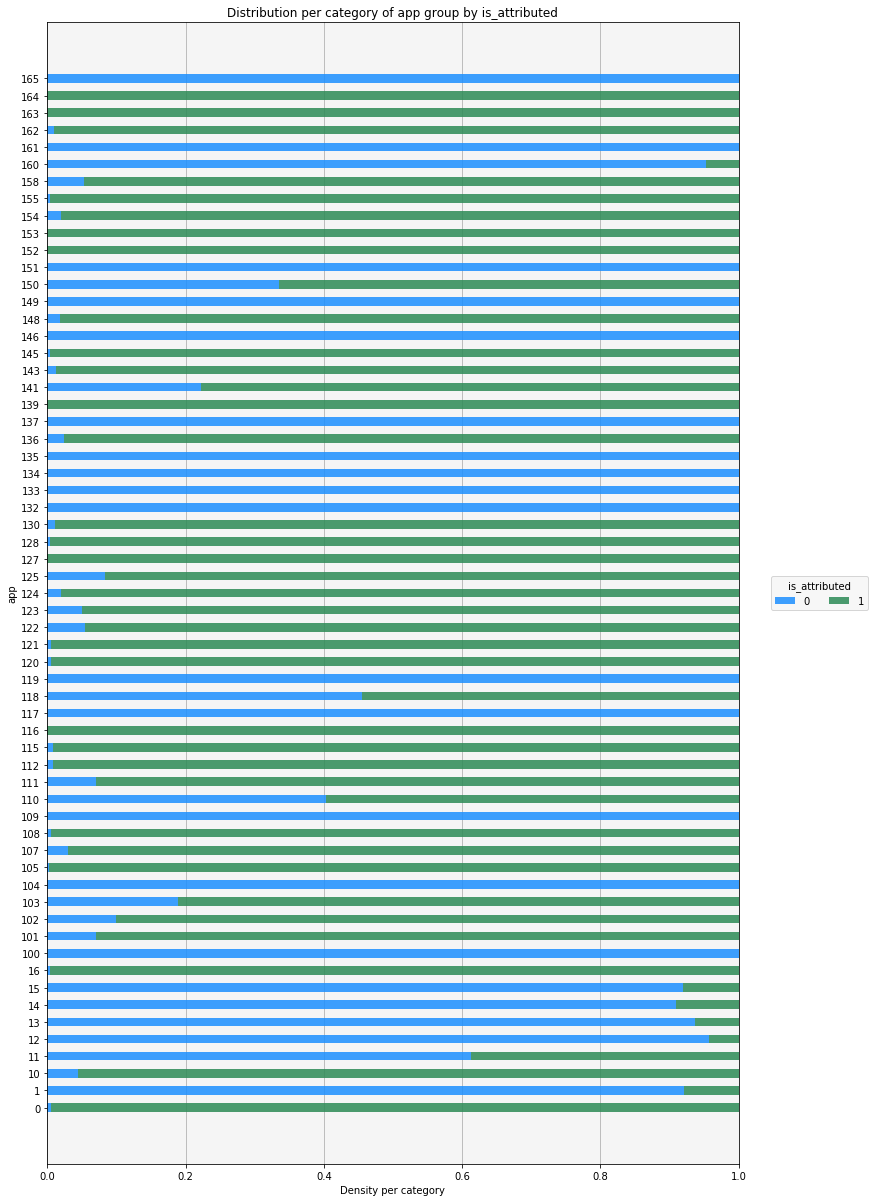

In [24]:
AdFraudDetection.set_figure_size((16,21))
AdFraudDetection.fully_stacked_bar(["app","is_attributed"],h=[1,1],limit_distinct_elements=100)
AdFraudDetection.set_figure_size()

We can really cluster the data using these new features. Let's see what we can extract with the application 116.

In [25]:
AdFraudDetection.filter("app=116")

912378 elements were filtered


In [26]:
AdFraudDetection["is_attributed"].describe()

,value
1,601


<column_matrix>

Let's now see the number of regular devices (perhaps some fraudulent machines are using devices that are not in the market?).

In [21]:
%%sql 
select count(distinct device) from
    (select
        device,
        (sum(is_attributed) over (partition by device))/456846 as ratio_total_downloading_device,
        (sum(is_attributed) over (partition by device))/(count(*) over (partition by device)) as ratio_downloading_device
    from vpython.AdFraudDetection_clean) x 
where ratio_downloading_device>=0.00001 or ratio_total_downloading_device>=0.001;

1 rows affected.


count
1868


Only 1868 different devices (less than half of the devices) seem to be used by regular users.

In [17]:
%%sql 
select count(distinct os) from
    (select
        os,
        (sum(is_attributed) over (partition by os))/456846 as ratio_total_downloading_os,
        (sum(is_attributed) over (partition by os))/(count(*) over (partition by os)) as ratio_downloading_os
    from vpython.AdFraudDetection_clean) x 
where ratio_downloading_os>=0.00001 or ratio_total_downloading_os>=0.001;

1 rows affected.


count
116


Only 116 OS (less than 1/6) seem to be used by regular users.

In [18]:
%%sql 
select count(distinct channel) from
    (select
        channel,
        (sum(is_attributed) over (partition by channel))/456846 as ratio_total_downloading_channel,
        (sum(is_attributed) over (partition by channel))/(count(*) over (partition by channel)) as ratio_downloading_channel
    from vpython.AdFraudDetection_clean) x 
where ratio_downloading_channel>=0.00001 or ratio_total_downloading_channel>=0.001;

1 rows affected.


count
174


30 channels seem to be really fraudulent.

In [19]:
%%sql 
select count(distinct app) from
    (select
        app,
        (sum(is_attributed) over (partition by app))/456846 as ratio_total_downloading_app,
        (sum(is_attributed) over (partition by app))/(count(*) over (partition by app)) as ratio_downloading_app
    from vpython.AdFraudDetection_clean) x 
where ratio_downloading_app>=0.00001 or ratio_total_downloading_app>=0.001;

1 rows affected.


count
226


Only 226 applications (less than 1/3) seem to be interesting.

We can see above some channels, app, os and devices where the downloading ratio is really low. They increase the cardinality of each elements and will increase the complexity of the ML algorithms. Let's now see some unusual behavior.

In [27]:
AdFraudDetection=RVD("AdFraudDetection_session",dsn="sandbox")
AdFraudDetection.filter("count_session_app_click>3")
AdFraudDetection.filter("session_duration>60")

80123147 elements were filtered
837432 elements were filtered


In [28]:
AdFraudDetection["is_attributed"].describe()

,value
0,103920675
1,22636


<column_matrix>

There is a real separation between typical users and fraudulent machines. The following examples show a specific case where there is more than one click per second during a short session.

In [30]:
AdFraudDetection=RVD("AdFraudDetection_session",dsn="sandbox")
AdFraudDetection.filter("count_session_click>session_duration")
AdFraudDetection.filter("count_session_click>4")
AdFraudDetection["is_attributed"].describe()

171776452 elements were filtered
10831528 elements were filtered


,value
0,2293901
1,2009


<column_matrix>

In [31]:
AdFraudDetection=RVD("AdFraudDetection_session",dsn="sandbox")
AdFraudDetection.filter("count_session_click>40")
AdFraudDetection.filter("session_duration<40")
AdFraudDetection["is_attributed"].describe()

96033061 elements were filtered
88851681 elements were filtered


,value
0,19096
1,52


<column_matrix>

The following example shows a weird behavior where the users are clicking a lot of time with a small IQR.

In [33]:
AdFraudDetection=RVD("AdFraudDetection_session",dsn="sandbox")
AdFraudDetection.filter("click_session_iqr<30 and count_session_app_click>4")
AdFraudDetection["is_attributed"].describe()

141416267 elements were filtered


,value
0,43479433
1,8190


<column_matrix>

The following scatter plot is showing the importance of the number of clicks per application which is suspect when it is too high.

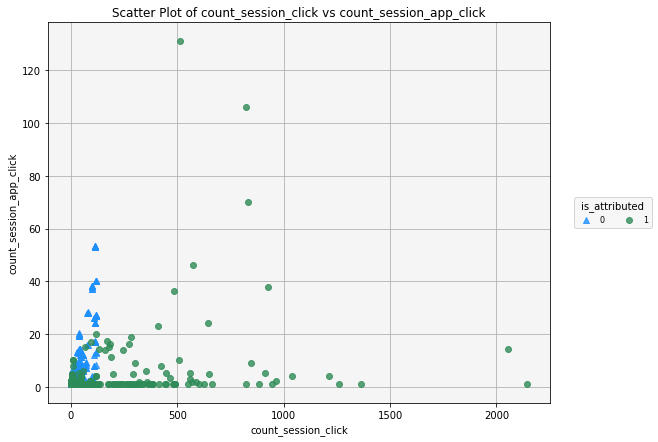

In [34]:
AdFraudDetection=RVD("AdFraudDetection_session",dsn="sandbox")
AdFraudDetection["count_session_click"].transformations+=[("{}+random()/3","float","float")]
AdFraudDetection["count_session_app_click"].transformations+=[("{}+random()/3","float","float")]
AdFraudDetection.scatter2D(["count_session_click","count_session_app_click","is_attributed"])

### <font color='#333333'>Moving Windows</font>

Another good idea that can be used for Fraud Detection is moving window. Let's see an example.

In [2]:
%%sql 
select 
    click_time,
    ip, 
    os,
    device,
    channel,
    app,
    count(*) over (partition by ip, os, device order by click_time range between '10 seconds' preceding and interval '10 seconds' following) as click_freq_user_btw_10sec,
    sum(is_attributed) over (partition by ip, os, device order by click_time range between '10 seconds' preceding and interval '10 seconds' following) as sum_dwn_user_btw_10sec
from AdFraudDetection order by ip, os, device, click_time limit 130;

130 rows affected.


click_time,ip,os,device,channel,app,click_freq_user_btw_10sec,sum_dwn_user_btw_10sec
2017-11-08 17:47:39,1,2,1,477,2,1,0
2017-11-08 20:08:39,1,2,1,477,2,1,0
2017-11-08 20:10:32,1,2,1,477,2,1,0
2017-11-08 22:03:35,1,2,1,477,2,1,0
2017-11-09 03:01:59,1,2,1,477,2,1,0
2017-11-09 14:34:09,1,2,1,449,14,4,0
2017-11-09 14:34:10,1,2,1,125,1,4,0
2017-11-09 14:34:11,1,2,1,449,18,4,0
2017-11-09 14:34:12,1,2,1,449,18,4,0
2017-11-08 22:20:54,1,3,1,469,13,1,0


We can really detect fraudulent activities when the number of clicks is really too high. In the precedent example we can see really irregular activities where the same user is clicking too many times in a 20 seconds interval. We can also notice that the downloading are mainly when the moving window catch only one element. The big question is which ones will be useful? The answer is many depending on the use case. For fraud detection we can try some experiment and see what the faster user in earth can do.

<img src="./images/click.png" width="600px">

Machine Learning is not the only solution but common sense mainly. The algorithms will help us to interpret a use case but it will never solve it. When we chew our food, it is mainly to help the stomach to not work too hard. It will be easier for your stomach to digest this:

<img src="./images/chew1.png" width="400px">

Rather than this:

<img src="./images/chew2.png" width="400px">

When we look at some Kaggle discussion, we can see that a lot of people are confounding Data Science and Brute Force.

<img src="./images/kaggle1.png" width="700px">

They are looking for gold medal. They forgot the real purpose of the competition and they mainly just want to improve their resume. Some are also sharing their entire code and ideas inside "kernels" during the competition.

<img src="./images/kaggle.png" width="700px">

They are sharing to become a "Kaggle Kernel Master" but at the end, many "data scientists" are copy-pasting their code and adding some additional variables which makes the leaderboard without real value. Models will be then without any originality. Helping people doesn't mean sharing direct code but some tips to try and which will help us to improve ourself.

A decision tree can be more accurate than a Gradient Boosting if it has the correct variable. At the end, moving windows can really help to detect Fraudulent Machines and even downloading in some cases. Using some of them, we can easily reach an AUC of 0.978

### <font color='#333333'>First conclusion and Features Engineering</font>

We detected many fraudulent machines and we know that they can download. We can easily understand that they will download after a huge number of clicks. Sessions and Moving windows helped us to understand this behavior but some variables can avoid the fraudulent machine downloading detection using a too strong segmentation. As the purpose of the competition is to predict if the click is a downloading one, we will use a very simple method. Let's now try to build a really easy model.
We will use the following variables:
<ul>
    <li>The next click time of the same ip</li>
    <li>The next click time of the same user</li>
    <li>The next click time of the same user and same app</li>
    <li>The number of clicks of the same ip per day</li>
    <li>The number of clicks of the same user per day</li>
    <li>The number of clicks of the same ip per hour</li>
    <li>The number of clicks of the same ip in the same app per day</li>
    <li>The number of cumulative clicks of the same user per day</li>
</ul>
The question is why these variables? the answer is that they are really easy to compute using any programming language and are very easy to understand. The downloading depends really on the next click. We noticed that fraudulent machines download after a really huge number of clicks and it is really rare to look many times at the same application.

In [18]:
%%sql
drop table if exists vpython.AdFraudDetection_model;
create table vpython.AdFraudDetection_model as
  select
        ip,
        is_attributed,
        click_time,
        channel,
        app,
        os,
        device,
        hour(click_time) as click_hour,
        coalesce(next_time_ip_click, 1000000) as t_next_ip_click,
        coalesce(next_time_ip_devos_click, 1000000) as t_next_ip_devos_click,
        coalesce(next_time_ip_devos_app_click, 1000000) as t_next_ip_devos_app_click,
        count(*) over (partition by ip, day(click_time)) as click_freq_ip,
        count(*) over (partition by ip, os, device, day(click_time)) as click_freq_ip_devos,
        count(*) over (partition by ip, app, day(click_time)) as click_freq_ip_app,
        count(*) over (partition by ip, day(click_time), hour(click_time)) as click_freq_ip_hour,
        row_number() over (partition by ip, os, device, day(click_time) order by click_time) - 1 as ip_devos_cumcount_clicks
    from
        (select 
            *,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip order by click_time))::int as next_time_ip_click,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip, device, os order by click_time))::int as next_time_ip_devos_click,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip, device, os, app order by click_time))::int as next_time_ip_devos_app_click
        from vpython.AdFraudDetection) x;

Done.
Done.


[]

### <font color='#333333'>Creating first Models</font>
The best model to choose for this dataset can be a GBM as it will find easily some patterns among the different features. It will be available in the next Vertica release. There are 4 binomial algorithms inside Vertica 9.0:
<ul>
    <li>Random Forest Classifier
    <li>Naive Bayes
    <li>SVM
    <li>Logistic Regression
</ul>
As the competition is based on the AUC and as Naive Bayes is not adapted, we can use two algorithms:
<ul>
    <li>Random Forest Classifier: we can directly use the different variables and try to find the perfect parameters.
    <li>Logistic Regression: we can not use all the variables and need some data preparation for the others.
</ul>
If our model is not good enough, we can use python GBM knowing that it is not necessary the best solution if we need to be fast. It is better to have a good model really easy to generalize rather than a very accurate model hard to put into production.

#### <font color='#1e90ff'>Logistic Regression</font>

We know that in these kind of use cases logistic regression is not really well adapted but let's see how far it will go.

The features to use to build this model are:
<ul>
    <li>all the new features</li>
    <li>channel_mean (as it is impossible to use a one hot encoder in so many categories)</li>
    <li>app_mean (as it is impossible to use a one hot encoder in so many categories)</li>
    <li>device_mean (as it is impossible to use a one hot encoder in so many categories)</li>
    <li>os_mean (as it is impossible to use a one hot encoder in so many categories)</li>
</ul>
Some of the features can be useless and will destroy the prediction. Let's build a model and then see what's going on.

First let's define our train and test set:
<ul>
    <li>We will learn on the day 7</li>
    <li>We will predict the behaviour on day 8</li>
</ul> 

In [2]:
%%sql
drop view if exists vpython.AdFraudDetection_model_train;
create view vpython.AdFraudDetection_model_train as
    select 
        t_next_ip_click,
        t_next_ip_devos_click,
        t_next_ip_devos_app_click,
        click_freq_ip,
        click_freq_ip_devos,
        click_freq_ip_app,
        click_freq_ip_hour,
        ip_devos_cumcount_clicks,
        channel_mean,
        app_mean,
        device_mean,
        os_mean,
        is_attributed
    from
        (select
            *,
            avg(is_attributed) over (partition by channel) as channel_mean,
            avg(is_attributed) over (partition by app) as app_mean,
            avg(is_attributed) over (partition by os) as os_mean,
            avg(is_attributed) over (partition by device) as device_mean
        from vpython.AdFraudDetection_model) x where day(click_time)=7;

Done.
Done.


[]

In [3]:
%%sql
drop view if exists vpython.AdFraudDetection_model_test;
create view vpython.AdFraudDetection_model_test as
    select 
        t_next_ip_click,
        t_next_ip_devos_click,
        t_next_ip_devos_app_click,
        click_freq_ip,
        click_freq_ip_devos,
        click_freq_ip_app,
        click_freq_ip_hour,
        ip_devos_cumcount_clicks,
        channel_mean,
        app_mean,
        device_mean,
        os_mean,
        is_attributed
    from
        (select
            *,
            avg(is_attributed) over (partition by channel) as channel_mean,
            avg(is_attributed) over (partition by app) as app_mean,
            avg(is_attributed) over (partition by os) as os_mean,
            avg(is_attributed) over (partition by device) as device_mean
        from vpython.AdFraudDetection_model) x where day(click_time)=8;

Done.
Done.


[]

Let's create the model.

In [6]:
%%sql 
drop model if exists logistic_reg_AdFraudDetection;
select logistic_reg('logistic_reg_AdFraudDetection',
                    'vpython.AdFraudDetection_model_train',
                    'is_attributed',
                    '*'
                    using parameters 
                        exclude_columns='is_attributed',
                        max_iterations=600, 
                        optimizer='BFGS'
                   );

        logistic_reg
-----------------------------
Finished in 229 iterations


We can then compute the AUC.

In [38]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     predict_logistic_reg(t_next_ip_click,
                                          t_next_ip_devos_click,
                                          t_next_ip_devos_app_click,
                                          click_freq_ip,
                                          click_freq_ip_devos,
                                          click_freq_ip_app,
                                          click_freq_ip_hour,
                                          ip_devos_cumcount_clicks,
                                          channel_mean,
                                          app_mean,
                                          device_mean,
                                          os_mean
                using parameters type='probability', model_name='logistic_reg_AdFraudDetection', match_by_pos=True) as prob 
                from vpython.AdFraudDetection_model_test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

      AUC
-----------------
0.952637202634249


Very good score for a Logistic Regression. We have to remember that as saw during the data exploration, logit is not adapted for this kind of use case except if we use a one hot encoder. We can then considerably increase the score and reach more than 0.98

#### <font color='#1e90ff'>Random Forest</font>

The features to use to build this model are the same than before except that RF handles categorical variable with less than 1000 categories (so app, os and channel are saved). However, we will simplify the model by splitting the categories figures. The tree will have a depth which will help to complete the number.

In [6]:
%%sql
drop view if exists vpython.AdFraudDetection_model_train;
create view vpython.AdFraudDetection_model_train as
    select 
        t_next_ip_click,
        t_next_ip_devos_click,
        t_next_ip_devos_app_click,
        click_freq_ip,
        click_freq_ip_devos,
        click_freq_ip_app,
        click_freq_ip_hour,
        ip_devos_cumcount_clicks,
        substr(right('000' || channel,3),1,1) as channel_0,
        substr(right('000' || channel,3),2,1) as channel_1,
        substr(right('000' || channel,3),3,1) as channel_2,
        substr(right('000' || os,3),1,1) as os_0,
        substr(right('000' || os,3),2,1) as os_1,
        substr(right('000' || os,3),3,1) as os_2,
        substr(right('000' || app,3),1,1) as app_0,
        substr(right('000' || app,3),2,1) as app_1,
        substr(right('000' || app,3),3,1) as app_2,
        substr(right('000' || device,3),1,1) as device_0,
        substr(right('000' || device,3),2,1) as device_1,
        substr(right('000' || device,3),3,1) as device_2,
        substr(right('000' || device,3),4,1) as device_3,
        is_attributed::varchar(1)
    from vpython.AdFraudDetection_model where day(click_time)=7;

Done.
Done.


[]

In [7]:
%%sql
drop view if exists vpython.AdFraudDetection_model_test;
create view vpython.AdFraudDetection_model_test as
    select 
        t_next_ip_click,
        t_next_ip_devos_click,
        t_next_ip_devos_app_click,
        click_freq_ip,
        click_freq_ip_devos,
        click_freq_ip_app,
        click_freq_ip_hour,
        ip_devos_cumcount_clicks,
        substr(right('000' || channel,3),1,1) as channel_0,
        substr(right('000' || channel,3),2,1) as channel_1,
        substr(right('000' || channel,3),3,1) as channel_2,
        substr(right('000' || os,3),1,1) as os_0,
        substr(right('000' || os,3),2,1) as os_1,
        substr(right('000' || os,3),3,1) as os_2,
        substr(right('000' || app,3),1,1) as app_0,
        substr(right('000' || app,3),2,1) as app_1,
        substr(right('000' || app,3),3,1) as app_2,
        substr(right('000' || device,3),1,1) as device_0,
        substr(right('000' || device,3),2,1) as device_1,
        substr(right('000' || device,3),3,1) as device_2,
        substr(right('000' || device,3),4,1) as device_3,
        is_attributed::varchar(1)
    from vpython.AdFraudDetection_model where day(click_time)=8;

Done.
Done.


[]

In [8]:
%%sql
drop model if exists rf_classifier_AdFraudDetection;
select rf_classifier('rf_classifier_AdFraudDetection',
                    'vpython.AdFraudDetection_model_train',
                    'is_attributed',
                    '*'
                    using parameters 
                        exclude_columns='is_attributed',
                        ntree=200,
                        sampling_size=0.7,
                        max_depth=30,
                        max_breadth=50,
                        nbins=100
                   );

   rf_classifier  
-------------------
 Finished training
(1 row)


In [39]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     predict_rf_classifier(t_next_ip_click,
                                           t_next_ip_devos_click,
                                           t_next_ip_devos_app_click,
                                           click_freq_ip,
                                           click_freq_ip_devos,
                                           click_freq_ip_app,
                                           click_freq_ip_hour,
                                           ip_devos_cumcount_clicks,
                                           channel_0,
                                           channel_1,
                                           channel_2,
                                           os_0,
                                           os_1,
                                           os_2,
                                           app_0,
                                           app_1,
                                           app_2,
                                           device_0,
                                           device_1,
                                           device_2,
                                           device_3
                using parameters type='probability', model_name='rf_classifier_AdFraudDetection', match_by_pos=True, class='1') as prob 
                from vpython.AdFraudDetection_model_test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

        AUC 
-------------------
 0.953971107806606


Not bad but not good enough yet because of the RF sensibility to outliers. Indeed, numerical features are transformed to categorical ones using bins and sometimes it is not the best idea. Let's try to find another solution.

### <font color='#333333'>Decision Trees</font>

Building a decision tree using SQL is quite easy it is a succession of conditions and groupby clauses. It can be a solution knowing the importance of some variables.

#### <font color='#1e90ff'>Creating a Test/Train</font>
As we know that the day 7 and 8 are complete, we will use the day 7 to predict the day 8. We created the variable is_attributed_test=is_attributed for day 7 and is null for day 8. This variable will be used in order to be sure of our predictions.

In [17]:
%%sql
drop table if exists vpython.AdFraudDetection_train_test;
create view vpython.AdFraudDetection_train_test as 
    select 
        *,
        (case when click_day=7 then is_attributed else null end) as is_attributed_test
    from vpython.AdFraudDetection_model where click_day=7 or click_day=8;

Done.
Done.


[]

#### <font color='#1e90ff'>Channel and App</font>

Let's see with only two clusters Channel and App.

In [16]:
%%sql
drop view if exists vpython.test;
create view vpython.test as
    select 
        is_attributed,
        prediction
    from
        (select 
            is_attributed,
            is_attributed_test,
            coalesce(avg(is_attributed_test) over (partition by channel,app),
                     avg(is_attributed_test) over (partition by channel),0) as prediction
        from vpython.AdFraudDetection_train_test) x where is_attributed_test is null;

Done.
Done.


[]

In [47]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     prediction as prob 
                from vpython.test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

        AUC 
-------------------
 0.958664686022229


Waw, very good AUC for only two features.

#### <font color='#1e90ff'>Channel, App and Os</font>
Let's try adding os.

In [15]:
%%sql
drop view if exists vpython.test;
create view vpython.test as
    select 
        is_attributed,
        prediction
    from
        (select 
            is_attributed,
            is_attributed_test,
            coalesce(avg(is_attributed_test) over (partition by channel,app,os),
                     avg(is_attributed_test) over (partition by channel,app),
                     avg(is_attributed_test) over (partition by channel),0) as prediction
        from vpython.AdFraudDetection_train_test) x where is_attributed_test is null;

Done.
Done.


[]

In [48]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     prediction as prob 
                from vpython.test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

        AUC 
-------------------
 0.959027694443687


We improved again the model.

#### <font color='#1e90ff'>Channel, App, Os and Device</font>

Now with device.

In [14]:
%%sql
drop view if exists vpython.test;
create view vpython.test as
    select 
        is_attributed,
        prediction
    from
        (select 
            is_attributed,
            is_attributed_test,
            coalesce(avg(is_attributed_test) over (partition by channel,app,os,device),
                     avg(is_attributed_test) over (partition by channel,app,os),
                     avg(is_attributed_test) over (partition by channel,app),
                     avg(is_attributed_test) over (partition by channel),0) as prediction
        from vpython.AdFraudDetection_train_test) x where is_attributed_test is null;

Done.
Done.


[]

In [49]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     prediction as prob 
                from vpython.test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

        AUC 
-------------------
 0.954349860055401


We are a little bit victim of overfitting. Let's try to use a minimum number of elements per clusters.

#### <font color='#1e90ff'>Channel, App, Os and Device with minimum Counts</font>

In [13]:
%%sql
drop view if exists vpython.test;
create view vpython.test as
    select 
        is_attributed,
        (case 
            when count_4>260 and avg_4 is not null then avg_4
            when count_3>260 and avg_3 is not null then avg_3
            when count_2>260 and avg_2 is not null then avg_2
            when count_1>=0 and avg_1 is not null then avg_1
            else 0
        end) as prediction
    from
        (select 
            is_attributed,
            is_attributed_test,
            count(*) over (partition by channel,app,os,device) as count_4,
            count(*) over (partition by channel,app,os) as count_3,
            count(*) over (partition by channel,app) as count_2,
            count(*) over (partition by channel) as count_1,
            avg(is_attributed_test) over (partition by channel,app,os,device) as avg_4,
            avg(is_attributed_test) over (partition by channel,app,os) as avg_3,
            avg(is_attributed_test) over (partition by channel,app) as avg_2,
            avg(is_attributed_test) over (partition by channel) as avg_1
        from vpython.AdFraudDetection_train_test) x where is_attributed_test is null;

Done.
Done.


[]

In [50]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     prediction as prob 
                from vpython.test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

        AUC 
-------------------
 0.962735158140017


Waww! We reached 0.963. Let's try to reach 0.97
#### <font color='#1e90ff'>Channel, App, Os, Device and Click Hour with minimum Counts</font>
We can see easily that the click hour destroy the prediction if it is used as groupby cluster. We saw during the data exploration that there are hours where the attributed time is really low. We can create this feature to use it as cluster but it will not improve the model. 


#### <font color='#1e90ff'>Channel, App, Os, Device, First session Click and Ratio App Click over Total Click</font>

For the following sql query, we will use sessions.
We identified some really useful information like the the number of click per session (here a session is defined as a  certain number of clicks and then 30 minutes of inactivity) and some weird values for the number of click per application. We can build the following decision tree.

In [12]:
%%sql
drop view if exists vpython.test;
create view vpython.test as
    select 
        is_attributed,
        (case 
            when count_4>260 and avg_4 is not null then avg_4+1/count_session_app_click*0.0003+ratio
            when count_3>260 and avg_3 is not null then avg_3+1/count_session_app_click*0.0003+ratio
            when count_2>260 and avg_2 is not null then avg_2+1/count_session_app_click*0.0003+ratio
            when count_1>=0 and avg_1 is not null then avg_1+1/count_session_app_click*0.0003+ratio
            else 1/count_session_app_click*0.008+ratio
        end) as prediction,
        count_session_click,
        count_session_app_click,
        session_duration
    from
        (select 
            is_attributed,
            is_attributed_test,
            count_session_click,
            count_session_app_click,
            click_iqr,
            session_duration,
            (case
                 when click_iqr<30 and count_session_app_click>1 and count_session_app_click/count_session_click>0.1 and count_session_app_click/count_session_click<0.4 then 0 else 0.0002 
            end) as ratio,
            count(*) over (partition by channel,app,os,device) as count_4,
            count(*) over (partition by channel,app,os) as count_3,
            count(*) over (partition by channel,app) as count_2,
            count(*) over (partition by channel) as count_1,
            avg(is_attributed_test) over (partition by channel,app,os,device) as avg_4,
            avg(is_attributed_test) over (partition by channel,app,os) as avg_3,
            avg(is_attributed_test) over (partition by channel,app) as avg_2,
            avg(is_attributed_test) over (partition by channel) as avg_1
        from vpython.AdFraudDetection_train_test) x where is_attributed_test is null;

Done.
Done.


[]

In [51]:
%%sql
select sum((true_positive_rate + prev_tpr) * (prev_fpr - false_positive_rate)/2) as AUC from
(
    select lag(true_positive_rate) over (order by false_positive_rate desc) as prev_tpr,
            lag(false_positive_rate) over (order by false_positive_rate desc) as prev_fpr, * from
    (
            select false_positive_rate, avg(true_positive_rate) as true_positive_rate from
            (
            select roc(obs::int, prob::float using parameters num_bins=20000) over() from 
                (select 
                     is_attributed as obs, 
                     prediction as prob 
                from vpython.test) as prediction_output
            ) q1 group by false_positive_rate 
    ) q2
) q3;

        AUC 
-------------------
 0.966472242734498


Impressive, we have a better score than some XGBoost on Kaggle. It is not enough to be in the Leaderboard but knowing that we can generalize this query, improve it and it is really simple to put it into production, we don't care about the 0.016 AUC which can make us first. Besides, we just used some variables. It will be more relevant if we build an entire tree (we can reach 0.97 with a good decision tree).

### <font color='#333333'>LightGBM and Kaggle submission</font>

We are ready for Kaggle. The last solution is not enough to have a really accurate score. We need an algorithms which can separate downloading clicks from the others. A solution is boosting.

<img src="./images/boosting.png" width="500px">

We will sum weak learners in order to create a very powerful model. LightGBM is one of those and is using some specific decision trees as weak learners (leaf-wise instead of level-wise).

<img src="./images/lightGBM.png" width="600px">

It proposes a lot of parameters to avoid overfitting and the user can choose the metric to optimize which can be really helpful.

You can find all the LightGBM references <a href='https://github.com/Microsoft/LightGBM'>here</a>.

#### <font color='#1e90ff'>Model Creation and Evaluation</font>


Let's now build the tables that will be used by the algorithm.

In [10]:
%%sql
drop view if exists vpython.AdFraudDetection_Kaggle_view;
create view vpython.AdFraudDetection_Kaggle_view as
    (select 
         null as click_id, 
         click_time, 
         ip,
         channel, 
         app, 
         os, 
         device, 
         is_attributed 
     from vpython.AdFraudDetection)
    union
    (select 
         click_id, 
         click_time, 
         ip,
         channel, 
         app, 
         os, 
         device, 
         null as is_attributed 
     from vpython.AdFraudDetection_f_test_and_sup);

Done.
Done.


[]

In [11]:
%%sql
drop table if exists vpython.AdFraudDetection_Kaggle;
create table vpython.AdFraudDetection_Kaggle as
  select
        ip,
        click_id,
        is_attributed,
        click_time,
        channel,
        app,
        os,
        device,
        hour(click_time) as click_hour,
        coalesce(t_next_ip_click, 1000000) as t_next_ip_click,
        coalesce(t_next_ip_devos_click, 1000000) as t_next_ip_devos_click,
        coalesce(t_next_ip_devos_app_click, 1000000) as t_next_ip_devos_app_click,
        count(*) over (partition by ip, day(click_time)) as click_freq_ip,
        count(*) over (partition by ip, os, device, day(click_time)) as click_freq_ip_devos,
        count(*) over (partition by ip, app, day(click_time)) as click_freq_ip_app,
        count(*) over (partition by ip, day(click_time), hour(click_time)) as click_freq_ip_hour,
        row_number() over (partition by ip, os, device, day(click_time) order by click_time) - 1 as ip_devos_cumcount_clicks
    from
        (select 
            *,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip order by click_time))::int as t_next_ip_click,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip, device, os order by click_time))::int as t_next_ip_devos_click,
            timestampdiff('second', click_time, lead(click_time) over (partition by ip, device, os, app order by click_time))::int as t_next_ip_devos_app_click
        from vpython.AdFraudDetection_Kaggle_view) x;

Done.
Done.


[]

After the data prep we can export the train and test file to csv files and export them to the Python cluster using the following commands.

In [ ]:
vsql -w vpython@vertica -F ',' -A -P footer=off -o AdFraud_train.csv -c "select * from vpython.AdFraudDetection_Kaggle where (day(click_time) = 7 or day(click_time) = 8) and is_attributed is not null";
scp ./AdFraud_train.csv root@10.3.230.121:/home/

In [ ]:
vsql -w vpython@vertica -F ',' -A -P footer=off -o AdFraud_eval.csv -c "select * from vpython.AdFraudDetection_Kaggle where day(click_time) = 9 and is_attributed is not null";
scp ./AdFraud_eval.csv root@10.3.230.121:/home/

In [ ]:
vsql -w vpython@vertica -F ',' -A -P footer=off -o AdFraud_test.csv -c "select * from vpython.AdFraudDetection_Kaggle where click_id is not null";
scp ./AdFraud_test.csv root@10.3.230.121:/home/

Let's now try to use the LightGBM.

In [22]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import lightgbm as lgb

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'max_bin': 255,
        'subsample': 0.8,
        'subsample_freq': 0,
        'colsample_bytree': 0.3,
        'min_child_weight': 5,
        'subsample_for_bin': 200000,
        'min_split_gain': 0,
        'reg_alpha': 0,
        'reg_lambda': 0,
        'nthread': 16,
        'verbose': 0,
        'metric':metrics
    }
    lgb_params.update(params)
    print("preparing validation datasets")
    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)
    evals_results = {}
    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)
    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])
    return bst1

path = './'
target = 'is_attributed'
predictors = ['channel','app','os','device','click_hour','t_next_ip_click','t_next_ip_devos_click',
              't_next_ip_devos_app_click','click_freq_ip','click_freq_ip_devos','ip_devos_cumcount_clicks',
              'ip_app_channel_count','ip_hour_channel_count']

categorical = ['app','os','device','channel','click_hour']

usecols_train = predictors+['is_attributed']
usecols_test = predictors+['click_id']
print('load train...')
train_df = pd.read_csv(path+"AdFraud_train.csv", usecols=usecols_train)
print('load eval...')
eval_df = pd.read_csv(path+"AdFraud_eval.csv", usecols=usecols_train)
print('load test...')
test_df = pd.read_csv(path+"AdFraud_test.csv", usecols=usecols_test)
print("Training...")
params = {
    'boosting_type': 'gbdt',
    'tree_learner' : 'data',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 15,  
    'max_depth': -1,  
    'min_data_in_leaf': 100, 
    'max_bin': 100,
    'min_data_in_bin': 10, 
    'subsample': 0.9, 
    'subsample_freq': 5,
    'colsample_bytree': 1,
    'min_child_weight': 0,
    'subsample_for_bin': 200000, 
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'verbose': 0,
    'scale_pos_weight': 100 
}
bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        eval_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=100, 
                        verbose_eval=True, 
                        num_boost_round=(200), 
                        categorical_features=categorical)
test_df['is_attributed'] = bst.predict(test_df[predictors])
print("writing...")
test_df.to_csv('prediction.csv',columns=['click_id','is_attributed'],index=False)
print("done...")
print("")
feature_name=bst.feature_name()
importance=bst.feature_importance(importance_type='split')
z=zip(importance,feature_name)
z.sort()
for item1,item2 in z:
    print(str(item1)+": "+str(item2))
print("")
feature_name=bst.feature_name()
importance=bst.feature_importance(importance_type='gain')
z=zip(importance,feature_name)
z.sort()
for item1,item2 in z:
    print(str(item1)+": "+str(item2))
print("")
feature_name=bst.feature_name()
importance=bst.feature_importance(importance_type='split')
gain=bst.feature_importance(importance_type='gain')
for i in range(len(importance)):
  importance[i]=gain[i]/importance[i]
z=zip(importance,feature_name)
z.sort()
for item1,item2 in z:
    print(str(item1)+": "+str(item2))
print("")

load train...
load eval...
load test...
Training...
preparing validation datasets
/usr/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[LightGBM] [Info] Number of positive: 305257, number of negative: 119894805
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data: 120200062, number of used features: 13
/usr/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')
Training until validation scores don't improve for 400 rounds.
[10]	train's auc: 0.971712	valid's auc: 0.966006
[20]	train's auc: 0.975975	valid's auc: 0.97133
[30]	train's auc: 0.978718	valid's auc: 0.974873
[40]	train's auc: 0.981271	valid's auc: 0.977667
[50]	train's auc: 0.982525	valid's auc: 0.978929
[60]	train's auc: 0.983558	valid's auc: 0.980084
[70]	train's auc: 0.984181	val

Waw, the model is much better than the others. Besides, the score in Kaggle is not bad "0.9805" (rank among the top 3 percent). We have to remember that the rank is not significant because of the huge amount of sharing in the "Kernels". Before the release of some "Kernels" users who reached a score more than "0.97" were really rare and the best score was less than "0.98". With this tutorial, we now know how to understand how to solve a very useful use case.

#### <font color='#1e90ff'>Understanding the Model</font>

Let's now try to understand the model. We are dealing with boosting. We are currently each round adding a week learner (decision tree) to boost the model. Reaching a certain number, the model is learning too much. The following graph shows the error rate of the training and the one of the evaluation among rounds.

In [25]:
from matplotlib import pyplot as plt
train = [0.971712,0.975975,0.978718,0.981271,0.982525,0.983558,0.984181,0.984585,0.984969,0.985205,0.985417,0.985599,0.985747,0.985882,0.986009,0.986129,0.986235,0.986339,0.986424,0.986497,0.98657,0.98665,0.98671,0.98678,0.986851,0.986903,0.98697,0.987021,0.987081,0.98712,0.98718,0.98723,0.987283,0.987342,0.9874,0.987442,0.987493,0.987538,0.987597,0.987646,0.987689,0.987738,0.987786,0.9878,0.987865,0.987899,0.987937,0.987976,0.988017,0.98805,0.988106,0.988142,0.988147,0.988168,0.988203,0.988242,0.988273,0.988315,0.988366,0.988401,0.988427,0.988454,0.988495,0.988532,0.988564,0.988596,0.988625,0.98865,0.988683,0.988715,0.988754,0.988783,0.988814,0.988848,0.988877,0.988916,0.988949,0.988969,0.988995,0.98900,0.98902,0.989059]
test = [0.966006,0.97133,0.974873,0.977667,0.978929,0.980084,0.980679,0.981066,0.981435,0.981627,0.981826,0.981956,0.982066,0.982171,0.982276,0.982335,0.982387,0.982439,0.982483,0.982527,0.98257,0.982597,0.98261,0.98264,0.982637,0.982651,0.98266,0.982668,0.982679,0.98268,0.98267,0.98268,0.982687,0.98270,0.982712,0.982706,0.982717,0.982717,0.982731,0.982732,0.982744,0.982747,0.982747,0.98274,0.982734,0.982728,0.982727,0.982728,0.982728,0.98273,0.982729,0.982714,0.982704,0.982704,0.982702,0.982695,0.982696,0.982696,0.982701,0.982702,0.982702,0.982702,0.982705,0.982702,0.982705,0.982695,0.982687,0.98269,0.982688,0.982681,0.982684,0.982676,0.982668,0.982655,0.982648,0.982638,0.982631,0.982629,0.982632,0.98263,0.982627,0.982618]
n = len(train)
error_train = [1-item for item in train]
error_test = [1-item for item in test]
step_train = [train[i+1]-train[i] for i in range(0,n-1)]
step_test = [test[i+1]-test[i] for i in range(0,n-1)]

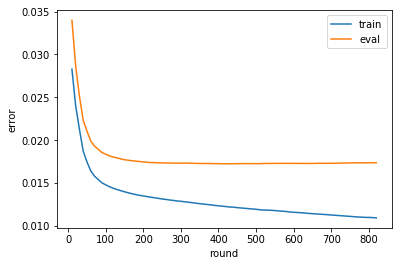

In [26]:
x = [10*i for i in range(1,n+1)]
plt.plot(x, error_train, label="train")
plt.plot(x, error_test, label="eval")
plt.xlabel('round')
plt.ylabel('error')
plt.legend()
plt.show()

It is totally normal than the optimization of the training set is better than the evaluation. However, after a small number of rounds the algorithm should find some general patterns which will optimize both the training and the evaluation. We can define the following function:

$$ratio(train,test)=\frac{train[i+1]-train[i]}{test[i+1]-test[i]}$$

It measures how much the algorithm is learning from the training compared to the evaluation. If it is approximately equal to 1 then the algorithm is learning general patterns. In the other case, we are dealing with overfitting.

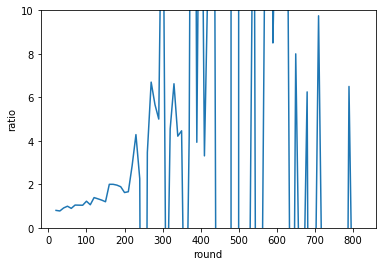

In [30]:
x = [10*(i+1) for i in range(1,n)]
y = [step_train[i]/(step_test[i]+0.000001) for i in range(0,n-1)]
plt.plot(x, y)
plt.xlabel('round')
plt.ylabel('ratio')
plt.ylim([0,10])
plt.show()

We can see that after round 200, the model is no longer learning well.

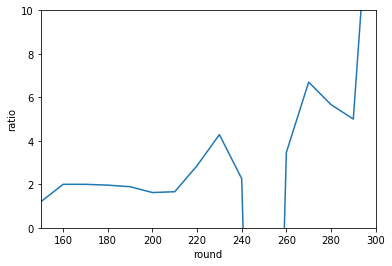

In [34]:
plt.plot(x, y)
plt.xlabel('round')
plt.ylabel('ratio')
plt.xlim([150,300])
plt.ylim([0,10])
plt.show()

We can see that the algorithm is victim of overfitting after round 220 and that the best number of rounds is around 200. Let's now see the variable importance. With the LightGBM, we have two choices (to see the total number of splits or the total gain). We must know that it is only indicative and the best way to test the variable importance is to retrieve it from the model. For example, it doesn't mean that a variable is not important because of a small number of splits. We can presume than to be important, it needs another variable and the two of them are really important together.

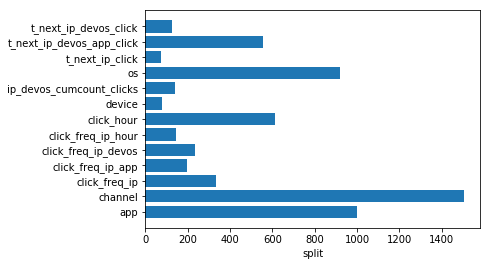

In [58]:
variables = ['t_next_ip_click','device','t_next_ip_devos_click','ip_devos_cumcount_clicks','click_freq_ip_hour','click_freq_ip_app','click_freq_ip_devos','click_freq_ip','t_next_ip_devos_app_click','click_hour','os','app','channel']
split = [73,78,125,142,145,196,236,334,557,612,919,999,1506]
plt.barh(variables, split)
plt.xlabel('split')
plt.show()

We can see a huge number of splits on the channel, app and os. Indeed, they are really important variables.

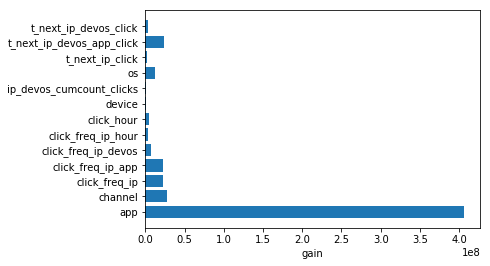

In [59]:
variables = ['ip_devos_cumcount_clicks','device','t_next_ip_click','t_next_ip_devos_click','click_freq_ip_hour','click_hour','click_freq_ip_devos','os','click_freq_ip','click_freq_ip_app','t_next_ip_devos_app_click','channel','app']
split = [486317.17474365234,1413481.930480957,1798323.919555664,3718529.9993896484,3909280.6041259766,4224709.342834473,7334981.486450195,11817018.83139038,22115429.673980713,22190225.48590088,23421661.311309814,27568886.182800293,406373689.4801941]
plt.barh(variables, split)
plt.xlabel('gain')
plt.show()

In the other hand the total gain is dominated by the app. It showed that the competition is more about downloading rather than fraud detection. Even if some machines are really fraudulent, the market is hard and people can have some common tastes. They will probably use to download some specific applications.

### <font color='#333333'>LightGBM UDF</font>

A User-Defined Extension (abbreviated as UDx) is a component that adds new abilities to the Vertica Analytics Platform. UDxs provide features such as new types of data analysis and the ability to parse and load new types of data. UDXs are developed using the APIs in the Vertica SDK. 

UDxs encompass functions such as User-Defined Scalar Functions (UDSFs), and utilities such as the User-Defined Load (UDL) or User-Defined Transform Functions (UDTFs), features that let you create custom data load routines or data transformation process.

For VERTICA SDK, an API is available for the following languages: 
<UL>
  <LI>C++</LI>
  <LI>JAVA</LI>
  <LI>Python</LI>
  <LI>R</LI>
</UL>

This gives extreme flexibility for the user to extend VERTICA functionality.

For this particular use case we decided to use <b>VERTICA SDK for R</b>. In our opinion that makes the whole implementation extremely easy.

#### <font color='#1e90ff'>Why UDX?</font>

Using UDX brings many benefits:
<UL>
    <LI>Extend functionality of VERTICA by building new custom features required by the organization, e.g. custom parsers, custom functions based on some commonly used libraries and SDKs.</LI>
    <LI>Ability to build new Machine Learning Models not available in the standard functionality.
    <LI>Boosting calculation speed, by ability to perform <b>in-database prediction,</b> without the necesity of transferring data between DB and ML component, what saves time.</LI>
    <LI>Fully leverage CPUs, Disks, Memory investments</LI>
    
</UL>

#### <font color='#1e90ff'>VERTICA and R</font>

We can identify basically two different R/Vertica programming approaches :
<UL>
    <LI>Standard R: R engine runs “outside” Vertica and interacts via ODBC/JDBC
    <LI>R-UDX: multiple R engines running “inside” Vertica and access data using “internal” interfaces 
</UL> 

#### <font color='#1e90ff'>"Standard R" approach</font>

In this approach, the R client (located on the external machine, not on the VERTICA cluster) is connecting to the database via a a RODBC connection. This is presented in the picture below:

<IMG SRC='images/picture1.png' width="800px"></IMG>

Having the <b><i>R engine</i></b> on a node other than the Database engine requires us to send all of the data via network for processing. The bigger the dataset, the more time is required  for processing. Also, when the <i>whole</i> data set cannot be loaded into memory the, process will simply fail. 

<UL>
<LI><b>Pros:</b> easier deployment, integration of the R-engine with graphic devices, interactive</LI>
<LI><b>Cons:</b> “slow” data extraction (Vertica ODBC/JDBC is still very fast)</LI>
</UL>


#### <font color='#1e90ff'>"R-UDX" approach</font>

In this approach, user R code is being run inside the VERTICA cluster (as subprocess), hence the data exchange between DB and  <b><i>R engine</i></b> is extremely fast, as interprocess communication is used. This is shown in this picture
<IMG SRC='images/picture2.png'></IMG>

In case of UDX written in R, the corresponding <i>"client R code"</i> calculating the specific data transformation can be converted into VERTICA R-UDX almost without modifications.
<UL>
<LI><b>Pros:</b> extremely fast data access, intrinsic Vertica parallelism, tight integration with the database</LI>
<LI><b>Cons:</b> resource competition, UDx have to be “deployed” (no interactivity)</LI>
</UL>


User-Defined Extensions (UDxs) are contained in <i>VERTICA Libraries</i>. The <i>VERTICA Library</i> can contain multiple UDxs. After the deployment, each UDx is available as a SQL function, which can be used as a <i>select</i> statement.

#### <font color='#1e90ff'>"R-UDX" approach vs "Standard R" approach</font>

Picture below summarizes performance tests in relation to size of the data set:
<IMG SRC='images/picture3.png' width="500px"></IMG>

#### <font color='#1e90ff'>UDX for AdFraudDetection competition on Kaggle</font>

For solving ML problem in this competition we decided to implement LightGradientBoost algorithm as R-UDX.

For this purpose we created 3 functions (available from SQL functions):
<UL>
<LI>LGBM_createmodel</LI>
<LI>LGBM_predict</LI>
<LI>LGBM_evaluate</LI>
</UL>

#### <font color='#1e90ff'>LGBM_createmodel</font>

The aim of this function is to build a model based on train data set, passed as an <b>argument</b> to the function. As a result, the function saves the trained model on a disk at the specified location.

<h4>Function <i>attributes</i>:</h4>
<UL>
 <LI> list of features passed to the algorithm for model creation. List of features(table columns) can be passed by naming them explicitly or using asterisk ("\*") <br>
Function can accept variable number of parametrers and types.<br>
<u>For example:</u><br>
        <code>select LGBM_createmodel(* using parameters file_name='file.dat') from T1;<br></code> 
 or<br>
        <code>select LGBM_createmodel(feature1,feature2,feature3 using parameters file_name='file.dat') from T1;<br></code> 
 
</LI>
</UL>
<h4>Function <i>parameters</i>:</h4>
<UL>
 <LI> file_name - where to put the file (char). <b>This is a mandatory parameter.</b></LI>
 <LI> response_column - name of the response column. <b>This is a mandatory parameter.</b></LI>
 <LI> params - json string that describes the algorithm's parameters. <b>This is a mandatory parameter.</b>
<br><u>Example:</u><br>

<code>{"boosting_type":"gbdt","tree_learner":"data","objective":"binary","metric":"auc","learning_rate":0.1,<br>"num_leaves":15,"max_depth":-1}
</code>
</LI>
</UL>
<h4>Function <i>returns</i>:</h4>
<UL>
 <LI> Information where model has been saved. </LI>
</UL>


<h4> R Code </h4>
    This is the primary part of <b>R</b> function that provides the required functionality:
    <br>
    <code>
    ....
    # create lgb.Dataset (based on input collumns)
    dtrain <- lgb.Dataset ( data = data.matrix(inputcols[,!(colnames(inputcols) == response.column.name)]),
    label=inputcols[,(colnames(inputcols) == response.column.name)]) 
    
    # train model using library function
    lgbm.model = lgb.train(alg_params, data=dtrain)
    # save model to file
    saveRDS.lgb.Booster(lgbm.model, fname)
    .....
    </code>
    
<h4> Sample SQL call() </h4> 

In [60]:
%%sql
select LGBM_createmodel(* using parameters file_name='/home/dbadmin/lgbm/model1.xxx', 
                            response_col_name='is_attributed', 
                            algorithm_params='{"boosting_type":"gbdt","tree_learner":"data","objective":"binary","metric":"auc","learning_rate":0.1,"num_leaves":15,"max_depth":-1,"min_data_in_leaf":100,"max_bin":100,"min_data_in_bin":10,"subsample":0.9,"subsample_freq":5,"colsample_bytree":1,"min_child_weight":0,"subsample_for_bin":200000,"min_split_gain":0,"reg_alpha":0,"reg_lambda":0,"verbose":0,"scale_pos_weight":100,"num_boost_round":5}'
                        ) over()
from vpython.AdFraudDetection;

Model saved in file: /home/dbadmin/lgbm/model1.xxx


#### <font color='#1e90ff'>LGBM_predict</font>

The aim of this function is to predict data using the previously trained model (as saved by function <b>LGBM_createmodel</b>)
and passed as an <b>parameter</b> to the function. Function returns list of features passed to the fucntion plus value of the predicted response column.


<h4>Function <i>attributes</i>:</h4>
<UL>
 <LI> list of features passed to the algorithm for model creation. List of features(table columns) can be passed by naming them explicitly or using asterisk ("\*") <br>
Function can accept variable number of parametrers and types, but should all match columns used for building the model.<br>
<u>For example:</u><br>
      r  <code>select LGBM_predict(* using parameters file_name='file.dat') from T1;<br></code> 
 or<br>
        <code>select LGBM_predict(feature1,feature2,feature3 using parameters file_name='file.dat') from T1;<br></code> 
 
</LI>
</UL>
<h4>Function <i>parameters</i>:</h4>
<UL>
 <LI> file_name - file path, containing the model  (char). <b>This is a mandatory parameter.</b></LI>
</UL>
<h4>Function <i>returns</i>:</h4>
<UL>
 <LI> list of values of features passed to the function plus value of the predicted response column</LI>
</UL>

<i>Please note that function is written such that it dynamicaly builds the list of the output columns and their types (as SQL specification requires) based on the list of columns passed to the function as attributes. <br>
This is a great flexibility, and allows the use of only one function to generate all models (<u>without the necessity of rebuilding/redefining the function for each new model based on a new list of features.</u>)</i> 

<h4> R Code </h4>
    This is main part of <b>R</b> function the that realizes required functionality:
<code>
        .....
        #read model from disk specified by fname variable
        lgbm.model <- readRDS.lgb.Booster(fname)
        #predict using the inputcolumns, store data in the prediction vector
        prediction <- predict(lgbm.model, data = data.matrix(inputcols))
        return ( cbind(inputcols, prediction))  #bind by column all input columns and the prediction columns;
        ......
</code>


<h4> Sample SQL call() </h4> 

In [63]:
%%sql
select LGBM_predict(* using parameters file_name='/home/dbadmin/lgbm/model1.xxx') over()
from 
    (select *, 
            count(*) over (partition by ip, device, os) as ip_dev_os_count
     from vpython.AdFraudDetection limit 10) in_query;

ip    |app |device |os |channel |click_time          |is_attributed |ip_dev_os_count |pred_result       |
------|----|-------|---|--------|--------------------|--------------|----------------|------------------|
49538 |23  |1      |12 |153     |2017-11-09 03:57:42 |0             |12              |0.17878006969969  |
49538 |23  |1      |12 |153     |2017-11-08 12:34:13 |0             |12              |0.17878006969969  |
49538 |18  |1      |12 |439     |2017-11-08 12:34:23 |0             |12              |0.203370365989848 |
49538 |18  |1      |12 |121     |2017-11-08 05:16:11 |0             |12              |0.178047959955197 |
49538 |15  |1      |12 |245     |2017-11-08 05:16:11 |0             |12              |0.178047959955197 |
49538 |15  |1      |12 |245     |2017-11-09 00:17:47 |0             |12              |0.178047959955197 |
49538 |15  |1      |12 |245     |2017-11-09 00:21:46 |0             |12              |0.178047959955197 |
49538 |15  |1      |12 |245     |2017-11-09 02

#### <font color='#1e90ff'>LGBM_evaluate</font>

The aim of this function is to evealuate model, and print importance of every feature within it.<br>
Model (as saved by function <b>LGBM_createmodel</b>) must be passed as an <b>parameter</b> to the function. Function returns list of features used by the model plus importance measuers in the model for each of them.


<h4>Function <i>attributes</i>:</h4>
<UL>
 <LI> Function does not require any attributes to be passed.
</LI>
</UL>
<h4>Function <i>parameters</i>:</h4>
<UL>
 <LI> file_name - file path, containing the model (char). <b>This is a mandatory parameter.</b></LI>
</UL>
<h4>Function <i>returns</i>:</h4>
<UL>
 <LI> <b>Feature</b> - Feature names in the model. </LI>
 <LI> <b>Gain</b> - The total gain of this feature's splits.</LI>
 <LI> <b>Cover</b> - The number of observation related to this feature.</LI>
 <LI> <b>Frequency</b> - The number of times a feature splited in trees. </LI>
</UL>


<h4> R Code </h4>
  This is main part of the <b>R</b> function that provides the required functionality:
  
<code>
         .....
         lgbm.model <- readRDS.lgb.Booster(fname)
         return ( lgb.importance(lgbm.model, percentage = FALSE))
         .....
</code>


<h4> Sample SQL call() </h4> 

In [62]:
%%sql
select LGBM_evaluate(using parameters file_name='/home/dbadmin/lgbm/model2.xxx') over();

Feature              |Gain             |Cover  |Frequency |
---------------------|-----------------|-------|----------|
ip_dev_os_count      |9943.83783721924 |73475  |11        |
app                  |7991.2855386734  |100472 |24        |
channel              |5881.50947809219 |33418  |28        |
ip                   |5519.70484638214 |21657  |21        |
ip_app_channel_count |1706.3288974762  |3192   |13        |
os                   |1575.24250602722 |6091   |15        |
click_time           |1029.31477165222 |3127   |23        |
device               |280.311004638672 |1314   |3         |
ip_dev_os_count_perh |135.197902679443 |359    |2         |


#### <font color='#1e90ff'>Note about UDX Library in VERTICA</font>

As it was mentioned above, all UDX must be stored under the library. SQL Code written below creates library for described UDXs as well as records in system tables for all UDXs described above.

This code  must be executed only once, as a part of the deployment process (or after any change in the R code for the function). No more actions are required to deploy UDXs on VERTICA cluster.  


<h4> SQL call: </h4> 

In [ ]:
%%sql
drop library if exists lib_lgbm cascade;
create library lib_lgbm AS '/home/dbadmin/lgbm/rudx_lgbm.R' language 'R';
create or replace transform function LGBM_createmodel as language 'R' name 'LGBM_createmodelFactory' library lib_lgbm fenced;
create or replace transform function LGBM_predict as language 'R' name 'LGBM_predictFactory' library  lib_lgbm fenced;
create or replace transform function LGBM_evaluate as language 'R' name 'LGBM_evaluateFactory' library  lib_lgbm fenced;

### <font color='#333333'>Entire Python Study</font>

#### <font color='#1e90ff'>Methodology</font>

The Kaggle Competition was billed as fraud detection, but the metric used was the area under the Receiver Operating Characteristic (AUC) for a prediction of whether a click resulted in a download of the app. We felt this was not the right metric for fraud detection. The clicks themselves are what are fraudulent, and the behavior of the clicks should help us determine fraudulent behavior regardless of whether the app is downloaded. Otherwise, what is to stop a fraudulent machine from undermining our detection system simply by downloading the app at the end of its session?



#### <font color='#1e90ff'>The Competition</font>

The TalkingData dataset is fairly large by Kaggle standards. With the training data containing 184,903,891 rows and 6 features, the .csv files comes out to over 7 gigabytes. This isn't necessarily Big Data, especially since TalkingData tracks over 3 billion clicks per day, but it is big enough to stretch an average laptop to the ends of its resources.



In [2]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

#Set chart style
sns.set()
%matplotlib inline

##### <font color='#666'>Exploratory Data Analysis (EDA)</font>

First, we create a random, 5% sample from the overall training set for EDA. This 5% will give us almost 6 million data points, so we should have plenty to work with. I save it for later use.

In [ ]:
chunksize = 10**6
frac = 0.10 #What fraction of the training set to capture.

df = pd.DataFrame()
for chunk in pd.read_csv('train.csv', chunksize=chunksize):
    sampled = chunk.sample(n=int(np.round(chunksibze*frac,0)))
    df = pd.concat([df, sampled], ignore_index=True)
df.to_csv('rand_5percent_train.csv', index=False)

In [3]:
df = pd.read_csv('rand_5percent_train.csv')

Now we convert click_time to a datetime object and create boolean columns to assist in plotting by day. We also read in the test supplement (a dummy column is created in the test supplement so it can be used in the plotting function as well).

In [4]:
df['click_time'] = pd.to_datetime(df['click_time'])
df['day7'] = df.click_time.dt.day == 7 # 1'st day
df['day8'] = df.click_time.dt.day == 8 # 2'nd day
df['day9'] = df.click_time.dt.day == 9 # 3'rd day

In [6]:
df_test = pd.read_csv('test_supplement.csv')
df_test['click_time'] = pd.to_datetime(df_test['click_time'])
df_test['day_test'] = df_test.click_time.dt.day == 10 # 4'th day(test)

Here I define a function to plot the number of clicks an ip makes each day.

In [7]:
def plot_count(df, tgt, c):
    '''Takes a DataFrame, target day, and color for plotting'''
    df = df[['ip', tgt]].groupby('ip')[tgt].sum().to_frame().reset_index()
    df[tgt+'_count'] = df[tgt].rolling(window=1000).mean()
    plt.plot(df.ip, df[tgt+'_count'], color=c)
    plt.xlim(0,364778)
    plt.ylabel('number of clicks')
    plt.xlabel('ip')

Plot each day 

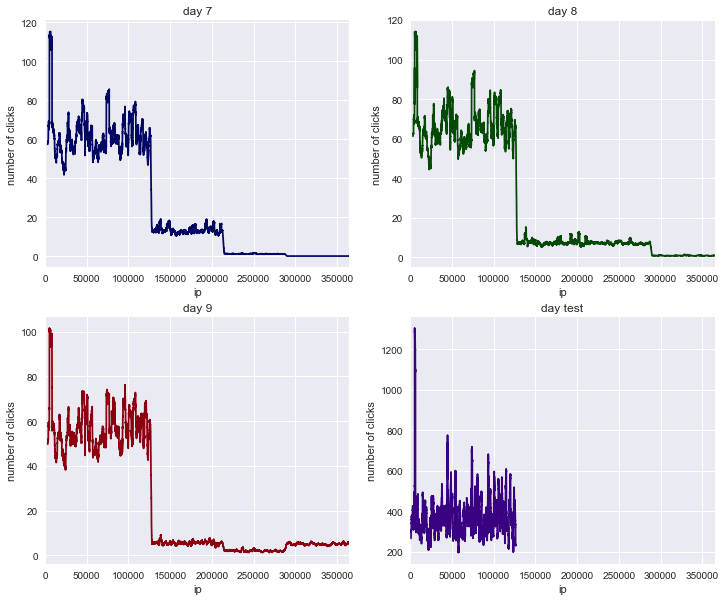

In [8]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plot_count(df, 'day7', 'xkcd:darkblue')
plt.title('day 7')

plt.subplot(2,2,2)
plot_count(df, 'day8', 'xkcd:darkgreen')
plt.title('day 8')

plt.subplot(2,2,3)
plot_count(df, 'day9', 'xkcd:crimson')
plt.title('day 9')

plt.subplot(2,2,4)
plot_count(df_test, 'day_test', 'xkcd:indigo')
plt.title('day test');

There are several things to notice here. First, ips less than approximately 125,000 click significantly more than those greater than 125,000.  Second, only these more frequent ips are in the test set. Third, there seems to be something of an ip segmentation by day, demarcated by the steep drop offs.

Next, let's look at the total downloads and download rates of ips.

First, I define a function to plot total downloads (recall that this is only 5% of the total training set, so actual numbers should be higher by roughly a factor of 20).

In [9]:
def print_attr_sum(df, color):
    df = df[['ip', 'is_attributed']].groupby('ip').is_attributed.sum().to_frame().reset_index()
    df['roll'] = df.is_attributed.rolling(window=1000).sum()
    plt.plot(df.ip, df.roll, c=color, alpha=0.7, linewidth=1)

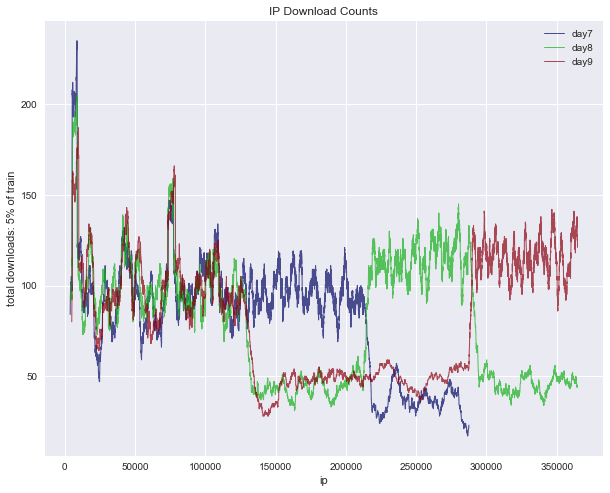

In [10]:
plt.figure(figsize=(10,8))
print_attr_sum(df[df.click_time.dt.day == 7], 'xkcd:darkblue')
print_attr_sum(df[df.click_time.dt.day == 8], 'xkcd:green')
print_attr_sum(df[df.click_time.dt.day == 9], 'xkcd:crimson')
plt.xlabel('ip')
plt.ylabel('total downloads: 5% of train')
plt.legend(['day7', 'day8', 'day9'], loc='best')
plt.title('IP Download Counts');

Notice that for the more frequent ips, total downloads are roughly equivalent to the less frequent ips, each averaging a little over 100. Also notice the interesting per day behavior. Certain ips are much more likely to download on certain days. This must be due to the ip encoding.

Let's check the download rates.

In [11]:
def print_attr_rate(df, color):
    df = df[['ip', 'is_attributed']].groupby('ip').is_attributed.mean().to_frame().reset_index()
    df['roll'] = df.is_attributed.rolling(window=1000).mean()
    plt.plot(df.ip, df.roll, c=color, alpha=0.7)
    plt.xlabel('ip')
    plt.ylabel('download rate/click: 5% of train')
    plt.legend(['day7', 'day8', 'day9'], loc='best')
    plt.title('IP Download Rates')

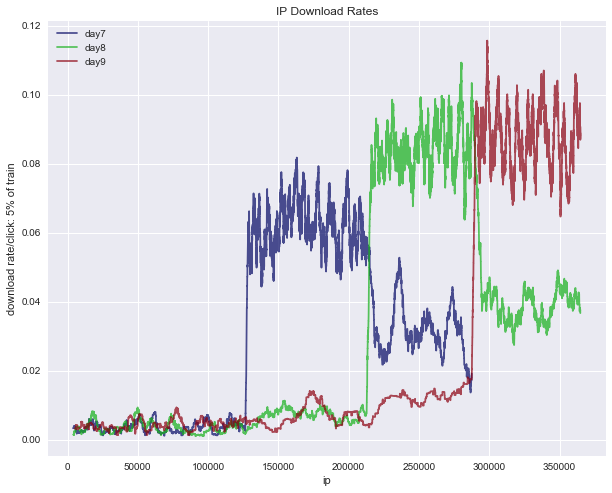

In [12]:
plt.figure(figsize=(10,8))
print_attr_rate(df[df.click_time.dt.day == 7], 'xkcd:darkblue')
print_attr_rate(df[df.click_time.dt.day == 8], 'xkcd:green')
print_attr_rate(df[df.click_time.dt.day == 9], 'xkcd:crimson')

This is what we expected. The most frequent ips have a very small download rate because they are so frequent. The other ips, each set prevelent on its own day, has a much higher download rate because the total clicks for these ips are much less, despite the roughly same number of downloads as the more frequent ones.

For all of these reasons, we decided to drop ip as a feature. Also, changing one's ip address is relatively simple, and fraudulent machines are sure to take advantage of this strategy.

##### <font color='#666'>Feature Creation</font>

In general, I tried to think about different ways to capture strange click behavior. The two primary characteristics I thought of were clicking too much and clicking too quickly. The features below all try to capture different combinations of ip, device, app, and os and see how much and how quickly these combintions were clicking.

In general, we treated a group of ip, os, and device as a single user. So the types and number of clicks made by these groups were of special import to us.

#### Engineered Features
* hour: hour of the day (categorical)
* ip_clicks_per_day: total number of clicks an ip made each day
* ip_day_hour_count_clicks: number of clicks an up made each hour
* ip_app_count_clicks: total number of clicks made by each ip-app combination
* ip_os_dev_count_clicks: total number of clicks made by each ip-os-device combination (i.e. each user)
* ip_os_dev_cumcount_clicks: running total number of clicks made by each ip-os-device combination
* ip_os_dev_cumcount_clicks_desc: same as above but begins with maximum value and counts down
* ip_dev_os_app_next_click: the number of seconds between successive clicks for each ip-device-os-app combination
* ip_dev_os_app_prev_click: the number of seconds between a click and the previous one for each ip-device-os-app combination
* ip_dev_os_next_click: the number of seconds between successive clicks for each ip-device-os combination
* ip_dev_os_prev_click: the number of seconds between a click and the previous one for each ip-device-os combination
* ip_dev_os_time_delta_std: the standard deviation of click_time differences for each ip-device-os combination
* ip_next_click: the number of seconds between successive clicks for each ip
* ip_devos_clicktime_count_click: number of simultaneous clicks for each ip-device-os combination


In [1]:
def create_features(df):
    '''Takes a raw DataFrame from the TalkingData dataset and creates interaction and time delta features.
    Returns a processed DataFrame ready for training.'''
    
    #Some quick time stamps to measure how long features take to create.
    tic = time.time() 
    time_report = {}
    
    #Exactracting the day and hour from the click_time feature
    print('Processing df and creating features...')
    toc = time.time()
    print('Making hour, day feature...')
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['hour'] = df['click_time'].dt.hour.astype('uint8')
    df['day'] = df['click_time'].dt.day.astype('uint8')
    time_report['day, hour'] = time.time()-toc
    
    #Group by ip and day, and counting the number of clicks in each group. This effectively calculates the
    #number of clicks each ip made on each day.
    print('Making ip_clicks_per_day...')
    toc = time.time()
    n_ip_day = df.groupby(by=['ip', 'day'])['click_time'].count().reset_index()
    n_ip_day.columns = ['ip', 'day', 'ip_clicks_per_day']
    df = df.merge(n_ip_day, on=['ip','day'], how='left')
    del n_ip_day
    gc.collect()
    time_report['ip_clicks_per_day'] = time.time() - toc
    
    #Group by ip, day, and hour and counting the number of clicks in each group. This effectively calculates the
    #number of clicks each ip made during each hour.
    toc = time.time()
    n_clicks = df[['ip','day','hour','click_time']].groupby(by=['ip','day',
          'hour'])[['click_time']].count().reset_index().rename(columns={'click_time': 'ip_day_hour_count_clicks'})
    df = df.merge(n_clicks, on=['ip','day','hour'], how='left')
    del n_clicks
    gc.collect()
    time_report['ip_day_hour_count_clicks'] = time.time()-toc
    
    #Group by ip, app and counting number of clicks in each group.
    toc = time.time()
    print('Making ip_app_count_clicks')
    n_clicks = df[['ip','app', 'click_time']].groupby(by=['ip', 
          'app'])[['click_time']].count().reset_index().rename(columns={'click_time': 'ip_app_count_clicks'})      
    df = df.merge(n_clicks, on=['ip','app'], how='left')
    del n_clicks
    gc.collect()
    time_report['ip_app_count_clicks'] = time.time()-toc
    
    #Group by ip, os, and device and cumulatively count the clicks.
    print('Making ip_os_dev_cumcount_clicks')
    toc = time.time()
    df['ip_os_dev_cumcount_clicks'] = df[['ip', 'device', 'os', 'click_time']].groupby(by=['ip', 'device', 'os']).cumcount().rename('ip_os_dev_cumcount_clicks')
    gc.collect()
    time_report['ip_os_dev_cumcount_clicks'] = time.time() - toc
    
    #Group by ip, os, and device and cumulatively count the clicks but in descending order. This works to capture the
    #high-count groups from both ends, ensuring that they are identified early and are thus treated as suspicious over
    #the entire training set.
    print('Making ip_os_dev_cumcount_clicks_desc')
    toc = time.time()
    df['ip_os_dev_cumcount_clicks_desc'] = df[['ip', 'device', 'os', 'click_time']].groupby(by=['ip', 'device', 'os']).cumcount(ascending=False).rename('ip_os_dev_cumcount_clicks')
    gc.collect()
    time_report['ip_os_dev_cumcount_clicks_desc'] = time.time() - toc
    
    #Grouping by ip, os, and device, counting the total number of clicks.
    print('Making ip_os_dev_count_clicks')
    toc = time.time()
    count_clicks = df[['ip', 'device', 'os', 'click_time']].groupby(by=['ip', 'device', 'os'])[['click_time']].count().reset_index().rename(columns={'click_time' : 'ip_os_dev_count_clicks'})
    print('Merging...')
    df = df.merge(count_clicks, on=['ip','device','os'], how='left')
    del count_clicks
    gc.collect()
    time_report['ip_os_dev_count_clicks'] = time.time() - toc
    
    #Grouping by ip, device, os, app then calculating the time until the next click. The last click in each group will be NaN
    #since there is no following click. 
    print('Making ip_dev_os_app_next_click feature...')
    toc = time.time()
    df['ip_dev_os_app_next_click'] = df[['ip', 'device', 'os', 'app','click_time']].groupby(['ip','device', 'os', 'app']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    time_report['ip_dev_os_app_next_click'] = time.time()-toc
    
    #Grouping by ip, device, and os then calculating the time until the next click. The last click in each group will be NaN
    #since there is no following click.
    print('Making ip_dev_os_next_click')
    toc = time.time()
    print('Grouping...')
    df['ip_dev_os_next_click'] = df[['ip', 'device', 'os', 'click_time']].groupby(['ip', 'device','os']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    time_report['ip_dev_os_next_click'] = time.time()-toc
    
    #Grouping by ip, device, and os then calculating the time until the previous click. The first click in each group will be NaN
    #since there is no following click. Overall, this data is largely
    #contained in the ascending version of this feature, but this feature will servce to emphasize the regular, fraudulent clicks.
    print('Making ip_dev_os_prev_click')
    toc = time.time()
    df['ip_dev_os_prev_click'] = df[['ip', 'device', 'os', 'click_time']].groupby(['ip', 'device','os']).click_time.transform(lambda x: x.diff()).dt.seconds
    time_report['ip_dev_os_prev_click'] = time.time()-toc
    
    #Grouping by ip, device, and os again, calculating the standard deviation of the time between successive clicks. Our
    #thinking here is that the more frequent, fraudulent clicks will decrease the standard deviation of the difference.
    print('Making ip_dev_os_time_delta_std')
    df['ip_dev_os_time_delta_std'] = df[['ip', 'device', 'os','ip_dev_os_next_click']].groupby(['ip', 'device','os']).ip_dev_os_next_click.transform(lambda x: x.std())
    time_report['ip_dev_os_time_delta_std'] = time.time()-toc
    
    #Grouping just by ip and calculating the time until the next click. The last click in each group will be NaN
    #since there is no following click.
    print('Making ip_next_click...')
    toc = time.time()
    df['ip_next_click'] = df[['ip', 'click_time']].groupby('ip').click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    time_report['ip_next_click'] = time.time()-toc
    
    #Grouping by ip, device, os, and app and calculating the amount of time to the previous click. Overall, this data is largely
    #contained in the ascending version of this feature, but this feature will servce to emphasize the regular, fraudulent clicks.
    print('Making ip_dev_os_app_prev_click feature...')
    toc = time.time()
    df['ip_dev_os_app_prev_click'] = df[['ip', 'device', 'os', 'app','click_time']].groupby(['ip','device', 'os', 'app']).click_time.transform(lambda x: x.diff()).dt.seconds
    time_report['ip_dev_os_app_prev_click'] = time.time()-toc
    
    #We discovered that some ip, device, os, app combinations had many identical click time's. In other words, some users were
    #clicking almost instantaneously. This grouping counts these identical, instant clicks.
    print('Making ip_device_os_app_clicktime_count_click...')
    toc = time.time()
    counts = df.groupby(['ip', 'device','os', 'app', 'click_time']).size().reset_index().rename(columns={0:'ip_devos_clicktime_count_click'})
    df = df.merge(counts, on=['ip', 'app','device', 'os', 'click_time'], how='left')
    time_report['ip_devos_clicktime_count_click'] = time.time()-toc                                                                                                                                          

    #We opted to drop the ip feature from the actual training data. 
    df = df.drop(['ip', 'click_time', 'day'], axis=1)
    
    #change variables to categoricals
    print('Convertings vars to categories...')
    toc = time.time()
    variables_cat = ['app', 'device', 'os', 'channel', 'hour']
    variables_ints = ['ip_clicks_per_day',
                      'ip_day_hour_count_clicks',
                      'ip_app_count_clicks',
                      'ip_os_dev_cumcount_clicks',
                      'ip_os_dev_cumcount_clicks_desc',
                      'ip_os_dev_count_clicks',
                      'ip_devos_clicktime_count_click'
                     ]
    for v in variables_cat:
        df[v] = df[v].astype('category')
    for v in variables_ints:
        df[v] = df[v].astype('uint16')
    time_report['converting vars'] = time.time()-toc
    print('Done!')
    time_report['Total'] = time.time()-tic
    pprint.pprint(time_report)
    return df

Note: for the sake of illustratin, and again due to the limits of my laptop, I'll be using 10% of each day for training and validation.

In [6]:
#Select day 7 and create features
df = pd.read_csv('ten_percent_7.csv')
proc = create_features(df)
del df
gc.collect()
proc.to_csv('ten_perecent7_proc.csv', index=False)
del proc
gc.collect()

Processing df and creating features...
Making hour, day feature...
Making ip_clicks_per_day...
Making ip_app_count_clicks
Making ip_os_dev_cumcount_clicks
Making ip_os_dev_cumcount_clicks_desc
Making ip_os_dev_count_clicks
Merging...
Making ip_dev_os_app_next_click feature...
Making ip_dev_os_next_click
Grouping...
Making ip_dev_os_prev_click
Making ip_dev_os_time_delta_std
Making ip_next_click...
Making ip_dev_os_app_prev_click feature...
Making ip_device_os_app_clicktime_count_click...
Convertings vars to categories...
Done!
{'Total': 3741.788521051407,
 'converting vars': 7.686162948608398,
 'day, hour': 2.935243844985962,
 'ip_app_count_clicks': 6.302624940872192,
 'ip_clicks_per_day': 3.2871158123016357,
 'ip_day_hour_count_clicks': 5.047043085098267,
 'ip_dev_os_app_next_click': 1553.6139242649078,
 'ip_dev_os_app_prev_click': 1192.776407957077,
 'ip_dev_os_next_click': 318.6559920310974,
 'ip_dev_os_prev_click': 312.9048840999603,
 'ip_dev_os_time_delta_std': 513.2694101333618,


42

In [7]:
#Select day 8 and create features
df = pd.read_csv('ten_percent_8.csv')
proc = create_features(df)
del df
gc.collect()
proc.to_csv('ten_perecent8_proc.csv', index=False)
del proc
gc.collect()

Processing df and creating features...
Making hour, day feature...
Making ip_clicks_per_day...
Making ip_app_count_clicks
Making ip_os_dev_cumcount_clicks
Making ip_os_dev_cumcount_clicks_desc
Making ip_os_dev_count_clicks
Merging...
Making ip_dev_os_app_next_click feature...
Making ip_dev_os_next_click
Grouping...
Making ip_dev_os_prev_click
Making ip_dev_os_time_delta_std
Making ip_next_click...
Making ip_dev_os_app_prev_click feature...
Making ip_device_os_app_clicktime_count_click...
Convertings vars to categories...
Done!
{'Total': 3114.817601919174,
 'converting vars': 2.9162566661834717,
 'day, hour': 2.2718758583068848,
 'ip_app_count_clicks': 8.516327142715454,
 'ip_clicks_per_day': 4.6441380977630615,
 'ip_day_hour_count_clicks': 7.709038019180298,
 'ip_dev_os_app_next_click': 1502.5446479320526,
 'ip_dev_os_app_prev_click': 784.8779628276825,
 'ip_dev_os_next_click': 315.76179099082947,
 'ip_dev_os_prev_click': 225.31233978271484,
 'ip_dev_os_time_delta_std': 374.50224876403

42

In [8]:
#Select day 9 and create features
df = pd.read_csv('ten_percent_9.csv')
proc = create_features(df)
del df
gc.collect()
proc.to_csv('ten_perecent9_proc.csv', index=False)
del proc
gc.collect()

Processing df and creating features...
Making hour, day feature...
Making ip_clicks_per_day...
Making ip_app_count_clicks
Making ip_os_dev_cumcount_clicks
Making ip_os_dev_cumcount_clicks_desc
Making ip_os_dev_count_clicks
Merging...
Making ip_dev_os_app_next_click feature...
Making ip_dev_os_next_click
Grouping...
Making ip_dev_os_prev_click
Making ip_dev_os_time_delta_std
Making ip_next_click...
Making ip_dev_os_app_prev_click feature...
Making ip_device_os_app_clicktime_count_click...
Convertings vars to categories...
Done!
{'Total': 1377.2336320877075,
 'converting vars': 1.092212200164795,
 'day, hour': 0.9484889507293701,
 'ip_app_count_clicks': 2.9952750205993652,
 'ip_clicks_per_day': 1.1012282371520996,
 'ip_day_hour_count_clicks': 2.1157519817352295,
 'ip_dev_os_app_next_click': 575.3423619270325,
 'ip_dev_os_app_prev_click': 408.713308095932,
 'ip_dev_os_next_click': 148.81391882896423,
 'ip_dev_os_prev_click': 108.27943086624146,
 'ip_dev_os_time_delta_std': 186.19628596305

42

#### Drawbacks
One large drawback to this process is that these features take a long time to create. Granted, I was only using a MacBook Air (8 GB 1600 MHz DDR3 RAM, 1.8 GHz Intel Core i5 CPU), but even to process a day's worth of clicks from the training data (roughly a third of the overall data), my laptop would need 3 or 4 hours. So to processs all the training data and the test supplement, I would have to leave my computer running overnight, as the entire process could take as many as 10 to 12 hours (and imagine my dismay when I did not properly test my code! 12 hours down the drain!).

The features that take the longest by far are the time delta features. This is primarily due to the fact that I was using an ad hoc lambda function and the .transform() pandas method. This is effectively looping through the dataset, hence the slow performance. Some of these calculations could probably be sped up using a vectorized implementation, but others like the standard deviation calculation could not be.

#### Dropping ip
We decided to drop the ip feature from the training data. This is mainly due to differences between the training and test sets introduced by how the ip feature was encoded.

#### Categorical Features
We set the features app, device, os, channel, and hour as categorical features. While pandas can store these categories, they must be set explicitly when creating the Light GBM Dataset.

#### Creating Features Separately by Day
Importantly, we created the features for each day separately. This means that the counts were reset for each day. This was done for several reasons. First, to make the data set easier to process given my limited resources. Second, it seems that the data was encoded by day, so training by day makes sense (see charts in section 1.1). A day is a relatively arbitrary cutoff, and could potentially weaken our model by slicing a session. See section on sessions for a better solution. However, one can easily imagine scenarious where analysis (e.g. counts) might need to carry over from one day to the next, so when dealing with the raw data at TalkingData, feature creation by day probably won't be necessary or desired.

#### Feature Creation on Test Set
TalkingData accidently released a larger test set originally, then continued to provide this test set (without support) so as to not lend an advantage to teams who had it. We computed our test set features using this larger test supplement. We then mapped the test supplement's click_id to the official test set's click_id, ran our predictions, and submitted.

##### <font color='#666'>Validation Procedure</font>

We decided to train our model on days 7 and 8, while using day 9 to validate. Day 9 is the most similar to the test set. 

##### <font color='#666'>Light GBM Model</font>

#### Creation of the Datasets

In [15]:
categories = [
    'app',
    'device',
    'os',
    'channel',
    'hour',
]

tic = time.time()
print('Reading in training data...')
train_df = pd.read_csv('ten_perecent7_proc.csv')
train_df = pd.concat([train_df, pd.read_csv('ten_perecent8_proc.csv')])

print('Converting to matrix...')
training_label = train_df.is_attributed.as_matrix()
training_data = train_df.drop('is_attributed', axis=1)
feature_names = list(training_data.columns.values)
training_data = training_data.as_matrix()

print('Making Training Dataset...')
dtrain = lgb.Dataset(training_data, label=training_label, feature_name=feature_names, categorical_feature=categories)
del train_df, training_label, training_data
gc.collect()
#print('Saving training Dataset...')
#dtrain.save_binary('dtrain78_ten_percent.bin')

print('Reading in validation data...')
valid = pd.read_csv('ten_perecent9_proc.csv')
valid_label = valid.is_attributed.as_matrix()
valid_data = valid.drop('is_attributed', axis=1).as_matrix()

print('Making Validation Dataset...')

dvalid = lgb.Dataset(valid_data, label=valid_label, feature_name=feature_names, categorical_feature=categories, reference='dtrain78.bin')
del valid, valid_label, valid_data
gc.collect()

#print('Saving Validation Dataset...')
#dvalid.save_binary('dvalid7.bin')
print('Done!')
print('Total seconds:', time.time() - tic)

Reading in training data...
Converting to matrix...
Making Training Dataset...
Reading in validation data...
Making Validation Dataset...
Done!
Total seconds: 108.23000884056091


When using larger fractions of the training data, this procedure would often crash my computer. The laptop would use the SSD as RAM, using up to 50 gigabytes at times.

#### Model Parameters

These were mainly chosen through reasoning about the nature of the data set and with some trial and error. If we had the resources, running a cross validation search grid would have been ideal. In general, we found that tuning parameters had a much smaller improvement in performance than feature engineering.

In [16]:
params = {
    'tree_learner' : 'data', #for faster training, doable since feature number is small
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1, #this is the default
    'num_leaves': 15,  #small number of leaves to prevent overfitting
    'max_depth': -1,  #no limit, light gbm uses leaf-wise growth, so control overfitting with num_leaves
    'min_data_in_leaf' : 100, 
    'max_bin': 100, #for faster training, and to avoid overfitting
    'min_data_in_bin': 10, #default 3
    'subsample': 0.9, 
    'subsample_freq': 5,
    'colsample_bytree': 1,
    'min_child_weight': 0,
    'subsample_for_bin': 200000, 
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 4,
    'scale_pos_weight': 100 #scale positive instances (is_attributed==1) because dataset is so unbalanced
}

#### Training

We used early stopping to ensure that we were not overfitting. We'll use the same parameters as above, and train for 220 rounds. Just in case we are still overfitting, we'll set the early stopping at 20 rounds. 

*Note: I coped the cell below from a notebook that used all of day 7 and 8 for training and used day 9 for validation. If you rerun this cell here, the validation AUC will not be quite this high since it will use only 10% of each day.*

In [19]:
bst = lgb.train(params, dtrain, 225, valid_sets=[dtrain,dvalid], valid_names=['Training', 'Validation'], early_stopping_rounds=20)

[1]	Training's auc: 0.966421	Validation's auc: 0.959543
Training until validation scores don't improve for 20 rounds.
[2]	Training's auc: 0.967204	Validation's auc: 0.960384
[3]	Training's auc: 0.969946	Validation's auc: 0.962911
[4]	Training's auc: 0.970817	Validation's auc: 0.963297
[5]	Training's auc: 0.972181	Validation's auc: 0.965261
[6]	Training's auc: 0.97297	Validation's auc: 0.966445
[7]	Training's auc: 0.973648	Validation's auc: 0.967184
[8]	Training's auc: 0.974591	Validation's auc: 0.967847
[9]	Training's auc: 0.975205	Validation's auc: 0.967959
[10]	Training's auc: 0.975902	Validation's auc: 0.968543
[11]	Training's auc: 0.976207	Validation's auc: 0.969097
[12]	Training's auc: 0.976326	Validation's auc: 0.969063
[13]	Training's auc: 0.976483	Validation's auc: 0.969188
[14]	Training's auc: 0.976621	Validation's auc: 0.969433
[15]	Training's auc: 0.976876	Validation's auc: 0.969812
[16]	Training's auc: 0.976953	Validation's auc: 0.969798
[17]	Training's auc: 0.977351	Valida

In [18]:
bst.save_model('bst.txt')

Let's plot the number of trees which use each feature.

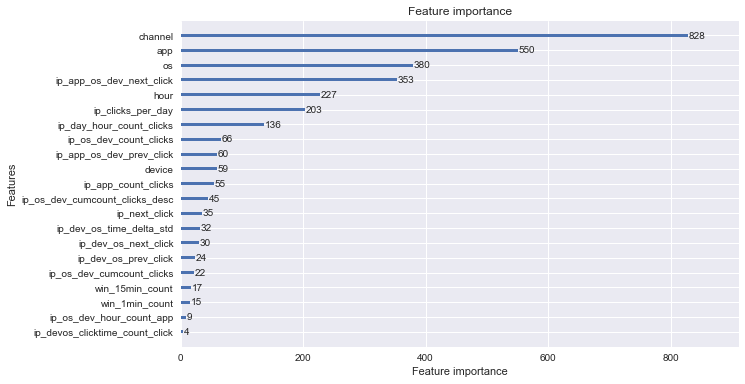

In [4]:
lgb.plot_importance(bst, ignore_zero=False, figsize=(10,6));

In [18]:
bst.save_model('bst.txt')

Let's plot the number of trees which use each feature.

We are ready to make our submission. We need to read in the processed test supplement, then use our mapping.csv to map the supplement's click_id to the official test set's. Then we can write it to a .csv and submit!

In [11]:
feature_names

['app',
 'device',
 'os',
 'channel',
 'hour',
 'ip_clicks_per_day',
 'ip_day_hour_count_clicks',
 'ip_app_count_clicks',
 'ip_os_dev_cumcount_clicks',
 'ip_os_dev_count_clicks',
 'ip_app_os_dev_next_click',
 'ip_dev_os_next_click',
 'ip_dev_os_time_delta_std',
 'ip_app_os_dev_prev_click',
 'ip_os_dev_cumcount_clicks_desc',
 'ip_devos_clicktime_count_click',
 'ip_dev_os_prev_click',
 'ip_next_click',
 'ip_os_dev_hour_count_app',
 'win_15min_count',
 'win_1min_count']

In [ ]:
submit = True

if submit:    
    old_test = pd.read_csv('test_sup_processed.csv')
    mapping = pd.read_csv('mapping.csv', dtype={'click_id': 'int32','old_click_id': 'int32'})
    old_test.rename(columns={'click_id': 'old_click_id'}, inplace=True)
    old_test = pd.merge(old_test, mapping, on=['old_click_id'], how='left')
    old_test.drop(['old_click_id'], axis=1, inplace=True)
    old_test['click_id'].fillna(-1, inplace=True)
    old_test['click_id'] = old_test['click_id'].astype(np.int32)
    old_test = old_test[old_test['click_id'] != -1]
    
    click_id = old_test.click_id
    test = old_test[feature_names].as_matrix()
    del old_test, mapping
    gc.collect()
    
    preds = bst.predict(test)
    
    submission = pd.DataFrame({'click_id':click_id, 'is_attributed':preds})
    submission.to_csv('submission.csv', index=False)
    submission.head()

With Python alone, we achieve some impressive results, but the resources needed to achive this within any kind of reasonable timeframe are immense. And these problems arise with only a small fraction of the data which Talking Data must contend with on a daily basis. This brief Python study serves to show that using SQL on the Vertica server is the prefered method for data analysis and fraud detection.

### <font color='#333333'>Conclusion</font>

During this competition, we learned many things. We can put the emphasis on the following points:
<ul>
    <li>Sessions and moving Windows are great for fraud detection (in that case a complete dataset is needed).</li>
    <li>The main business is not "downloading" tracking as users will always change their IP. The company can not assign specific value to them except if it has access to a real ID. However Fraud Detection is a real problem as many applications are wasting money on adds.</li>
    <li>Kaggle competitions are not adapted to the context of big data as they are only judging the optimization of the error function, whereas in  reality, the time and variance of the models are highly important. Besides, sharing codes will destroy the creativity of a lot of people.</li>
    <li>The company needs to understand each variable used in the model and its importane in order to create their own models in the future. It is a real business case and not a "funny" competition.</li>
</ul>

### <font color='#333333'>The Team</font>

<table>
    <tr>
        <td><img src="./images/about-badr.png" width="600px" height="170px"></td>
        <td><p><b>Badr Ouali</b> <br><br> Badr Ouali is a young Data Scientist working for Vertica. He studied engineering and received a degree in Computer Science / Mathematics and a Master's degree in Data Science. Badr enjoys sharing his knowledge and skill sets with others. He loves his job and is available to help his team in any way he can!</p></td>
    </tr>
    <tr>
        <td><img src="./images/about-chad.png" width="600px" height="170px"></td>
        <td><p><p><b>Chad Gardner</b> <br><br> Chad Gardner holds a degree in Astronomy and taught high school physics for several years. He holds a degree in Astronomy and a Masters in the History and Philosophy of Science. His interests include all things Python, visualization, teaching, and deep learning. He is now a novice data scientist doing freelance work and looking to transition to the field full time.</p></td>
    </tr>
    <tr>
        <td><img src="./images/about-maciej.png" width="600px" height="170px"></td>
        <td><p><p><b>Maciej Paliwoda</b> <br><br> Maciej Paliwoda is a Vertica Solution Architect. He worked more than 20 years in IT. He is a big fan of Vertica and he really enjoys playing with the R language. He had a first contact with ML (decision trees algorithms) during MSc and PhD studies. He returned to the Big Data world after many years of break. He really enjoys Data Science and he likes trying to find solutions to really complex problems.</p></td>
    </tr>
</table>